# Quickstart Example of Advanced Off-Policy Evaluation and Selection (continuous)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic simulation dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from basicgym import BasicEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the Synthetic environment works.

#### RL setup for Synthetic
In Synthetic , the objective of the RL agent is to maximize reward

We often formulate this synthetic  problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: State observation, which may be noisy in POMDPs.
- `action`:  Indicating the action to presented by the RL agent.
- `reward`: Reward observation.


<!-- For more about the environmental configuration and its customization, please refer to [examples/quickstart/synthetic_synthetic_customize_env.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_customize_env.ipynb). -->

In [9]:
# standardized environment for continuous action
# env = gym.make("SyntheticEnv-continuous-v0")
env = gym.make("BasicEnv-continuous-v0")

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Synthetic environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

<!-- For more about the data collection and visualization, please refer to [examples/quickstart/synthetic_synthetic_data_collection.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_data_collection.ipynb). -->

In [11]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        # minimum=0.1,   # 0.1
        # maximum=10,  # 10
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [12]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=10000,
    n_steps_per_epoch=100,
    update_start_step=100,
    # n_steps=100000,
    # n_steps_per_epoch=1000,
    # update_start_step=1000,
)

2023-03-13 21:17.33 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230313211733
2023-03-13 21:17.33 [debug    ] Fitting action scaler...       action_scler=min_max
2023-03-13 21:17.33 [debug    ] Building model...
2023-03-13 21:17.33 [debug    ] Model has been built.
2023-03-13 21:17.33 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230313211733/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 21:17.33 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230313211733/model_100.pt
2023-03-13 21:17.33 [info     ] SAC_online_20230313211733: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0010830163955688477, 'time_environment_step': 0.00012717247009277343, 'time_step': 0.001270453929901123, 'rollout_return': 27.85133207765433, 'evaluation': 25.152896913444685} step=100
2023-03-13 21:17.33 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230313211733/model_200.pt
2023-03-13 21:17.33 [info     ] SAC_online_20230313211733: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0008410596847534179, 'time_environment_step': 0.00011375188827514649, 'time_step': 0.0010054731369018555, 'rollout_return': 28.314461598110114, 'evaluation': 25.318735026011666} step=200
2023-03-13 21:17.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230313211733/model_300.pt
2023-03-13 21:17.34 [info     ] SAC_online_20230313211733: epoc

In [13]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [12]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

In [13]:
behavior_policy_05 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([0.5]),
    name="sac_sigma_0.5",
    random_state=random_state,
)
behavior_policy_10 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)
behavior_policy_20 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([2.0]),
    name="sac_sigma_2.0",
    random_state=random_state,
)
behavior_policies = [behavior_policy_05, behavior_policy_10, behavior_policy_20]

In [14]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [17]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    path="synthetic/logged_dataset/",
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    path="synthetic/logged_dataset/",
    random_state=random_state + 1,
)

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
with open("logs/train_dataset_continuous_sac_5.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac_5.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [15]:
with open("logs/train_dataset_continuous_sac_5.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac_5.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

<!-- For more about the offline RL procedure, please refer to [examples/quickstart/synthetic_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_basic.ipynb). -->

In [16]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import CQL, IQL

In [17]:
# evaluation policies
cql_b1 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b2 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b3 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b1 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b2 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b3 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

algorithms = [cql_b1, cql_b2, cql_b3, iql_b1, iql_b2, iql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3", "iql_b1", "iql_b2", "iql_b3"]

In [18]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [23]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 22:02.13 [debug    ] RandomIterator is selected.
2023-03-13 22:02.13 [info     ] Directory is created at d3rlpy_logs/CQL_20230313220213
2023-03-13 22:02.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:02.13 [debug    ] Building models...
2023-03-13 22:02.13 [debug    ] Models have been built.
2023-03-13 22:02.13 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313220213/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:08.23 [info     ] CQL_20230313220213: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0013635287523269654, 'time_algorithm_update': 0.03429723012447357, 'temp_loss': -0.10635324658264872, 'temp': 1.1986660577058792, 'alpha_loss': 5.678730954127759, 'alpha': 0.6964215415537357, 'critic_loss': 409.7646963911176, 'actor_loss': -42.5727622762084, 'time_step': 0.03665678174495697} step=10000
2023-03-13 22:08.23 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313220213/model_10000.pt
2023-03-13 22:08.23 [debug    ] RandomIterator is selected.
2023-03-13 22:08.23 [info     ] Directory is created at d3rlpy_logs/CQL_20230313220823
2023-03-13 22:08.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:08.23 [debug    ] Building models...
2023-03-13 22:08.23 [debug    ] Models have been built.
2023-03-13 22:08.23 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313220823/params.json params={'action_scaler': {'type': 'min_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:14.03 [info     ] CQL_20230313220823: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0013698978424072266, 'time_algorithm_update': 0.03131512365341187, 'temp_loss': -0.11791282761287876, 'temp': 1.1944059588491918, 'alpha_loss': 4.45109770816341, 'alpha': 0.7088291254162788, 'critic_loss': 501.3531763156414, 'actor_loss': -46.954522895979885, 'time_step': 0.03366596343517304} step=10000
2023-03-13 22:14.03 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313220823/model_10000.pt
2023-03-13 22:14.03 [debug    ] RandomIterator is selected.
2023-03-13 22:14.03 [info     ] Directory is created at d3rlpy_logs/CQL_20230313221403
2023-03-13 22:14.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:14.03 [debug    ] Building models...
2023-03-13 22:14.03 [debug    ] Models have been built.
2023-03-13 22:14.03 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313221403/params.json params={'action_scaler': {'type': 'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:17.30 [info     ] CQL_20230313221403: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008685660839080811, 'time_algorithm_update': 0.01899409863948822, 'temp_loss': -0.16382122719134204, 'temp': 1.2089265888690948, 'alpha_loss': 5.320056339340703, 'alpha': 0.7015914004653693, 'critic_loss': 442.043402322948, 'actor_loss': -43.953698689836266, 'time_step': 0.020465347266197205} step=10000
2023-03-13 22:17.30 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313221403/model_10000.pt
2023-03-13 22:17.30 [debug    ] RandomIterator is selected.
2023-03-13 22:17.30 [info     ] Directory is created at d3rlpy_logs/IQL_20230313221730
2023-03-13 22:17.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:17.30 [debug    ] Building models...
2023-03-13 22:17.30 [debug    ] Models have been built.
2023-03-13 22:17.30 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313221730/params.json params={'action_scaler': {'type': 'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:18.35 [info     ] IQL_20230313221730: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007449504852294922, 'time_algorithm_update': 0.005280945992469787, 'critic_loss': 321.43972929594514, 'value_loss': 0.4476774816583793, 'actor_loss': -25.558037630967796, 'time_step': 0.006413039803504944} step=10000
2023-03-13 22:18.35 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313221730/model_10000.pt
2023-03-13 22:18.35 [debug    ] RandomIterator is selected.
2023-03-13 22:18.35 [info     ] Directory is created at d3rlpy_logs/IQL_20230313221835
2023-03-13 22:18.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:18.35 [debug    ] Building models...
2023-03-13 22:18.35 [debug    ] Models have been built.
2023-03-13 22:18.35 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313221835/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:19.35 [info     ] IQL_20230313221835: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007467021226882935, 'time_algorithm_update': 0.004835496950149536, 'critic_loss': 344.19510643582345, 'value_loss': 0.6748346960362261, 'actor_loss': -43.83762755352315, 'time_step': 0.005970650744438172} step=10000
2023-03-13 22:19.35 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313221835/model_10000.pt
2023-03-13 22:19.35 [debug    ] RandomIterator is selected.
2023-03-13 22:19.35 [info     ] Directory is created at d3rlpy_logs/IQL_20230313221935
2023-03-13 22:19.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:19.35 [debug    ] Building models...
2023-03-13 22:19.35 [debug    ] Models have been built.
2023-03-13 22:19.35 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313221935/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:20.39 [info     ] IQL_20230313221935: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007409934759140015, 'time_algorithm_update': 0.005231450247764588, 'critic_loss': 328.06789174764157, 'value_loss': 0.484983622217461, 'actor_loss': -30.562521674396844, 'time_step': 0.006352353167533875} step=10000
2023-03-13 22:20.39 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313221935/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 22:20.40 [debug    ] RandomIterator is selected.
2023-03-13 22:20.40 [info     ] Directory is created at d3rlpy_logs/CQL_20230313222040
2023-03-13 22:20.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:20.40 [warning  ] Skip building models since they're already built.
2023-03-13 22:20.40 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313222040/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:23.52 [info     ] CQL_20230313222040: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007767799615859986, 'time_algorithm_update': 0.017793775153160094, 'temp_loss': 0.040519753186032174, 'temp': 1.2802111378192902, 'alpha_loss': 2.862944107055664, 'alpha': 0.2790731763035059, 'critic_loss': 429.1662415649414, 'actor_loss': -46.262838973236086, 'time_step': 0.019111225199699402} step=10000
2023-03-13 22:23.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313222040/model_10000.pt
2023-03-13 22:23.52 [debug    ] RandomIterator is selected.
2023-03-13 22:23.52 [info     ] Directory is created at d3rlpy_logs/CQL_20230313222352
2023-03-13 22:23.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:23.52 [warning  ] Skip building models since they're already built.
2023-03-13 22:23.52 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313222352/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:28.00 [info     ] CQL_20230313222352: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008013549566268921, 'time_algorithm_update': 0.02321531574726105, 'temp_loss': 0.04178924262137152, 'temp': 1.2467241435408591, 'alpha_loss': 2.675336130285263, 'alpha': 0.28145594499558213, 'critic_loss': 528.2605112304688, 'actor_loss': -51.819943773651126, 'time_step': 0.02456913206577301} step=10000
2023-03-13 22:28.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313222352/model_10000.pt
2023-03-13 22:28.00 [debug    ] RandomIterator is selected.
2023-03-13 22:28.00 [info     ] Directory is created at d3rlpy_logs/CQL_20230313222800
2023-03-13 22:28.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:28.00 [warning  ] Skip building models since they're already built.
2023-03-13 22:28.00 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313222800/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:31.10 [info     ] CQL_20230313222800: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007703999280929565, 'time_algorithm_update': 0.017550555515289307, 'temp_loss': 0.0322856739168521, 'temp': 1.3302808057546616, 'alpha_loss': 2.85726319026947, 'alpha': 0.28012242931723597, 'critic_loss': 461.47337064208983, 'actor_loss': -47.78497761001587, 'time_step': 0.018858425855636598} step=10000
2023-03-13 22:31.10 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313222800/model_10000.pt
2023-03-13 22:31.10 [debug    ] RandomIterator is selected.
2023-03-13 22:31.10 [info     ] Directory is created at d3rlpy_logs/IQL_20230313223110
2023-03-13 22:31.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:31.10 [warning  ] Skip building models since they're already built.
2023-03-13 22:31.10 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313223110/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:32.14 [info     ] IQL_20230313223110: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007410109758377075, 'time_algorithm_update': 0.005276928901672364, 'critic_loss': 415.49010029296875, 'value_loss': 0.2876751214444637, 'actor_loss': -15.071392717170715, 'time_step': 0.006357685232162476} step=10000
2023-03-13 22:32.14 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313223110/model_10000.pt
2023-03-13 22:32.14 [debug    ] RandomIterator is selected.
2023-03-13 22:32.14 [info     ] Directory is created at d3rlpy_logs/IQL_20230313223214
2023-03-13 22:32.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:32.14 [warning  ] Skip building models since they're already built.
2023-03-13 22:32.15 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313223214/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fact

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:33.14 [info     ] IQL_20230313223214: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007437114238739013, 'time_algorithm_update': 0.004836323404312134, 'critic_loss': 437.70067744750975, 'value_loss': 0.40627557525336744, 'actor_loss': -23.910184781599046, 'time_step': 0.00592495436668396} step=10000
2023-03-13 22:33.14 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313223214/model_10000.pt
2023-03-13 22:33.14 [debug    ] RandomIterator is selected.
2023-03-13 22:33.14 [info     ] Directory is created at d3rlpy_logs/IQL_20230313223314
2023-03-13 22:33.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:33.14 [warning  ] Skip building models since they're already built.
2023-03-13 22:33.14 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313223314/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fact

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:34.18 [info     ] IQL_20230313223314: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007430982828140259, 'time_algorithm_update': 0.0052484527349472045, 'critic_loss': 427.903325163269, 'value_loss': 0.3387919153138995, 'actor_loss': -18.828011375904083, 'time_step': 0.006331322407722473} step=10000
2023-03-13 22:34.18 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313223314/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 22:34.19 [debug    ] RandomIterator is selected.
2023-03-13 22:34.19 [info     ] Directory is created at d3rlpy_logs/CQL_20230313223419
2023-03-13 22:34.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:34.19 [warning  ] Skip building models since they're already built.
2023-03-13 22:34.19 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313223419/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:37.22 [info     ] CQL_20230313223419: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000775525426864624, 'time_algorithm_update': 0.016816633248329164, 'temp_loss': 0.5180401608787477, 'temp': 0.6881725724339485, 'alpha_loss': 0.14387766090826226, 'alpha': 0.1423460394449532, 'critic_loss': 386.15128927459716, 'actor_loss': -46.808064322280885, 'time_step': 0.018129604434967042} step=10000
2023-03-13 22:37.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313223419/model_10000.pt
2023-03-13 22:37.22 [debug    ] RandomIterator is selected.
2023-03-13 22:37.22 [info     ] Directory is created at d3rlpy_logs/CQL_20230313223722
2023-03-13 22:37.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:37.22 [warning  ] Skip building models since they're already built.
2023-03-13 22:37.22 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313223722/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:42.27 [info     ] CQL_20230313223722: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008066927671432496, 'time_algorithm_update': 0.028969854521751402, 'temp_loss': 0.5548093324590474, 'temp': 0.6578677252113819, 'alpha_loss': 0.20773013489926234, 'alpha': 0.1357957115381956, 'critic_loss': 414.274521383667, 'actor_loss': -48.53395737495423, 'time_step': 0.03032473638057709} step=10000
2023-03-13 22:42.27 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313223722/model_10000.pt
2023-03-13 22:42.27 [debug    ] RandomIterator is selected.
2023-03-13 22:42.27 [info     ] Directory is created at d3rlpy_logs/CQL_20230313224227
2023-03-13 22:42.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:42.27 [warning  ] Skip building models since they're already built.
2023-03-13 22:42.27 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313224227/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimu

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:45.32 [info     ] CQL_20230313224227: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007706101655960083, 'time_algorithm_update': 0.01701448757648468, 'temp_loss': 0.6029954758169129, 'temp': 0.7259638414770365, 'alpha_loss': 0.18182293579919498, 'alpha': 0.13847282027304172, 'critic_loss': 394.0046321670532, 'actor_loss': -47.21439717712402, 'time_step': 0.018319537568092348} step=10000
2023-03-13 22:45.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313224227/model_10000.pt
2023-03-13 22:45.32 [debug    ] RandomIterator is selected.
2023-03-13 22:45.32 [info     ] Directory is created at d3rlpy_logs/IQL_20230313224532
2023-03-13 22:45.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:45.32 [warning  ] Skip building models since they're already built.
2023-03-13 22:45.32 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313224532/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mini

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:46.37 [info     ] IQL_20230313224532: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007553265571594238, 'time_algorithm_update': 0.005353350949287415, 'critic_loss': 365.9288448348999, 'value_loss': 0.25435939098373056, 'actor_loss': -6.822161183306575, 'time_step': 0.006466283559799195} step=10000
2023-03-13 22:46.37 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313224532/model_10000.pt
2023-03-13 22:46.37 [debug    ] RandomIterator is selected.
2023-03-13 22:46.37 [info     ] Directory is created at d3rlpy_logs/IQL_20230313224637
2023-03-13 22:46.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:46.37 [warning  ] Skip building models since they're already built.
2023-03-13 22:46.37 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313224637/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_facto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:47.38 [info     ] IQL_20230313224637: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007517167091369628, 'time_algorithm_update': 0.004856530594825745, 'critic_loss': 380.6385582778931, 'value_loss': 0.3232620405420661, 'actor_loss': -10.428429554152489, 'time_step': 0.00596079773902893} step=10000
2023-03-13 22:47.38 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313224637/model_10000.pt
2023-03-13 22:47.38 [debug    ] RandomIterator is selected.
2023-03-13 22:47.38 [info     ] Directory is created at d3rlpy_logs/IQL_20230313224738
2023-03-13 22:47.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:47.38 [warning  ] Skip building models since they're already built.
2023-03-13 22:47.38 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313224738/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factor

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:48.41 [info     ] IQL_20230313224738: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007422419309616088, 'time_algorithm_update': 0.005240774154663086, 'critic_loss': 381.41015107421873, 'value_loss': 0.32511925886273385, 'actor_loss': -10.330744862496854, 'time_step': 0.0063304683446884155} step=10000
2023-03-13 22:48.42 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313224738/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 22:48.42 [debug    ] RandomIterator is selected.
2023-03-13 22:48.42 [info     ] Directory is created at d3rlpy_logs/CQL_20230313224842
2023-03-13 22:48.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:48.42 [warning  ] Skip building models since they're already built.
2023-03-13 22:48.42 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313224842/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:51.45 [info     ] CQL_20230313224842: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007790554285049438, 'time_algorithm_update': 0.01679293248653412, 'temp_loss': 0.07032686800911324, 'temp': 0.326120305788517, 'alpha_loss': 0.06743218606074479, 'alpha': 0.0661570736411959, 'critic_loss': 385.4365681304932, 'actor_loss': -47.8044994682312, 'time_step': 0.01811268301010132} step=10000
2023-03-13 22:51.45 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313224842/model_10000.pt
2023-03-13 22:51.45 [debug    ] RandomIterator is selected.
2023-03-13 22:51.45 [info     ] Directory is created at d3rlpy_logs/CQL_20230313225145
2023-03-13 22:51.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:51.45 [warning  ] Skip building models since they're already built.
2023-03-13 22:51.45 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313225145/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:55.49 [info     ] CQL_20230313225145: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007926836490631103, 'time_algorithm_update': 0.022950959515571596, 'temp_loss': 0.07910859277804848, 'temp': 0.3043038396522403, 'alpha_loss': 0.06673265103673257, 'alpha': 0.06186588188000024, 'critic_loss': 381.53165079803466, 'actor_loss': -47.75839656677246, 'time_step': 0.024293272948265075} step=10000
2023-03-13 22:55.49 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313225145/model_10000.pt
2023-03-13 22:55.49 [debug    ] RandomIterator is selected.
2023-03-13 22:55.49 [info     ] Directory is created at d3rlpy_logs/CQL_20230313225549
2023-03-13 22:55.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:55.49 [warning  ] Skip building models since they're already built.
2023-03-13 22:55.49 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313225549/params.json params={'action_scaler': {'type': 'min_max', 'params': {'m

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:58.55 [info     ] CQL_20230313225549: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000781207537651062, 'time_algorithm_update': 0.01704044930934906, 'temp_loss': 0.0854530958091229, 'temp': 0.33511517175137995, 'alpha_loss': 0.06703352674338076, 'alpha': 0.06357459710910916, 'critic_loss': 385.64757400665286, 'actor_loss': -47.65159525871277, 'time_step': 0.018361740684509277} step=10000
2023-03-13 22:58.55 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313225549/model_10000.pt
2023-03-13 22:58.55 [debug    ] RandomIterator is selected.
2023-03-13 22:58.55 [info     ] Directory is created at d3rlpy_logs/IQL_20230313225855
2023-03-13 22:58.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:58.55 [warning  ] Skip building models since they're already built.
2023-03-13 22:58.55 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313225855/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 22:59.59 [info     ] IQL_20230313225855: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007393712520599366, 'time_algorithm_update': 0.005312343692779541, 'critic_loss': 344.3129090911865, 'value_loss': 0.12220875168181956, 'actor_loss': -3.4487730799376966, 'time_step': 0.006386133933067322} step=10000
2023-03-13 22:59.59 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313225855/model_10000.pt
2023-03-13 22:59.59 [debug    ] RandomIterator is selected.
2023-03-13 22:59.59 [info     ] Directory is created at d3rlpy_logs/IQL_20230313225959
2023-03-13 22:59.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 22:59.59 [warning  ] Skip building models since they're already built.
2023-03-13 22:59.59 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313225959/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fact

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:00.59 [info     ] IQL_20230313225959: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007413072109222412, 'time_algorithm_update': 0.004884272336959839, 'critic_loss': 353.79535429992677, 'value_loss': 0.10542741547003388, 'actor_loss': -3.1352092892900107, 'time_step': 0.0059654291868209836} step=10000
2023-03-13 23:00.59 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313225959/model_10000.pt
2023-03-13 23:01.00 [debug    ] RandomIterator is selected.
2023-03-13 23:01.00 [info     ] Directory is created at d3rlpy_logs/IQL_20230313230100
2023-03-13 23:01.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:01.00 [warning  ] Skip building models since they're already built.
2023-03-13 23:01.00 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313230100/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fa

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:02.04 [info     ] IQL_20230313230100: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007379173278808593, 'time_algorithm_update': 0.005302980542182922, 'critic_loss': 363.240492906189, 'value_loss': 0.10050778263919055, 'actor_loss': -3.1987995061829686, 'time_step': 0.00637998948097229} step=10000
2023-03-13 23:02.04 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313230100/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 23:02.04 [debug    ] RandomIterator is selected.
2023-03-13 23:02.04 [info     ] Directory is created at d3rlpy_logs/CQL_20230313230204
2023-03-13 23:02.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:02.04 [warning  ] Skip building models since they're already built.
2023-03-13 23:02.04 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313230204/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:05.04 [info     ] CQL_20230313230204: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007817265033721924, 'time_algorithm_update': 0.016512873530387877, 'temp_loss': 0.061689090876400586, 'temp': 0.1856046873435378, 'alpha_loss': -0.6252616722986102, 'alpha': 0.0836940148729831, 'critic_loss': 446.9650642745972, 'actor_loss': -51.60287024688721, 'time_step': 0.01784664056301117} step=10000
2023-03-13 23:05.04 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313230204/model_10000.pt
2023-03-13 23:05.04 [debug    ] RandomIterator is selected.
2023-03-13 23:05.04 [info     ] Directory is created at d3rlpy_logs/CQL_20230313230504
2023-03-13 23:05.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:05.04 [warning  ] Skip building models since they're already built.
2023-03-13 23:05.04 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313230504/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:08.21 [info     ] CQL_20230313230504: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007887566804885864, 'time_algorithm_update': 0.018162754225730895, 'temp_loss': 0.049593006547167896, 'temp': 0.1568339260086417, 'alpha_loss': -0.5012046895489096, 'alpha': 0.07909288257323205, 'critic_loss': 371.16401508331296, 'actor_loss': -47.232837675857546, 'time_step': 0.019505166864395143} step=10000
2023-03-13 23:08.21 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313230504/model_10000.pt
2023-03-13 23:08.21 [debug    ] RandomIterator is selected.
2023-03-13 23:08.21 [info     ] Directory is created at d3rlpy_logs/CQL_20230313230821
2023-03-13 23:08.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:08.21 [warning  ] Skip building models since they're already built.
2023-03-13 23:08.21 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313230821/params.json params={'action_scaler': {'type': 'min_max', 'params': {

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:11.20 [info     ] CQL_20230313230821: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000776613712310791, 'time_algorithm_update': 0.016366391468048094, 'temp_loss': 0.04243030832251534, 'temp': 0.1964097047328949, 'alpha_loss': -0.520082053399086, 'alpha': 0.08351084023602307, 'critic_loss': 372.2743910614014, 'actor_loss': -47.00070257911682, 'time_step': 0.017689055943489074} step=10000
2023-03-13 23:11.20 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313230821/model_10000.pt
2023-03-13 23:11.20 [debug    ] RandomIterator is selected.
2023-03-13 23:11.20 [info     ] Directory is created at d3rlpy_logs/IQL_20230313231120
2023-03-13 23:11.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:11.20 [warning  ] Skip building models since they're already built.
2023-03-13 23:11.20 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313231120/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mini

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:12.25 [info     ] IQL_20230313231120: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007492727994918824, 'time_algorithm_update': 0.005403758549690246, 'critic_loss': 287.789093460083, 'value_loss': 0.2498397143855691, 'actor_loss': -0.8397192292571067, 'time_step': 0.006517164969444275} step=10000
2023-03-13 23:12.25 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313231120/model_10000.pt
2023-03-13 23:12.25 [debug    ] RandomIterator is selected.
2023-03-13 23:12.25 [info     ] Directory is created at d3rlpy_logs/IQL_20230313231225
2023-03-13 23:12.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:12.25 [warning  ] Skip building models since they're already built.
2023-03-13 23:12.25 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313231225/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factor

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:13.27 [info     ] IQL_20230313231225: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007561444044113159, 'time_algorithm_update': 0.004995922470092774, 'critic_loss': 300.1193868270874, 'value_loss': 0.23215983975827695, 'actor_loss': -0.28273163871262225, 'time_step': 0.0061135591268539425} step=10000
2023-03-13 23:13.27 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313231225/model_10000.pt
2023-03-13 23:13.27 [debug    ] RandomIterator is selected.
2023-03-13 23:13.27 [info     ] Directory is created at d3rlpy_logs/IQL_20230313231327
2023-03-13 23:13.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:13.27 [warning  ] Skip building models since they're already built.
2023-03-13 23:13.27 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313231327/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fa

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:14.33 [info     ] IQL_20230313231327: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007499128103256225, 'time_algorithm_update': 0.005414312052726746, 'critic_loss': 306.514444631958, 'value_loss': 0.19712334704101087, 'actor_loss': -0.45134727659691126, 'time_step': 0.006523601818084717} step=10000
2023-03-13 23:14.33 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313231327/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 23:14.34 [debug    ] RandomIterator is selected.
2023-03-13 23:14.34 [info     ] Directory is created at d3rlpy_logs/CQL_20230313231434
2023-03-13 23:14.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:14.34 [warning  ] Skip building models since they're already built.
2023-03-13 23:14.34 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313231434/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:17.35 [info     ] CQL_20230313231434: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007789504289627075, 'time_algorithm_update': 0.016666697692871095, 'temp_loss': -0.046496460654231485, 'temp': 0.11917079675719142, 'alpha_loss': -1.31196325468421, 'alpha': 0.24317328237146138, 'critic_loss': 364.75466696777346, 'actor_loss': -46.96052185440063, 'time_step': 0.017995821523666383} step=10000
2023-03-13 23:17.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313231434/model_10000.pt
2023-03-13 23:17.35 [debug    ] RandomIterator is selected.
2023-03-13 23:17.35 [info     ] Directory is created at d3rlpy_logs/CQL_20230313231735
2023-03-13 23:17.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:17.35 [warning  ] Skip building models since they're already built.
2023-03-13 23:17.35 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313231735/params.json params={'action_scaler': {'type': 'min_max', 'params': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:21.21 [info     ] CQL_20230313231735: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007953156948089599, 'time_algorithm_update': 0.021103199625015258, 'temp_loss': -0.005513752758386545, 'temp': 0.14780696171224117, 'alpha_loss': -1.3629767678439617, 'alpha': 0.23629720706939697, 'critic_loss': 364.1895725326538, 'actor_loss': -46.8514584892273, 'time_step': 0.022456482887268068} step=10000
2023-03-13 23:21.21 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313231735/model_10000.pt
2023-03-13 23:21.22 [debug    ] RandomIterator is selected.
2023-03-13 23:21.22 [info     ] Directory is created at d3rlpy_logs/CQL_20230313232122
2023-03-13 23:21.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:21.22 [warning  ] Skip building models since they're already built.
2023-03-13 23:21.22 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313232122/params.json params={'action_scaler': {'type': 'min_max', 'params': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:24.19 [info     ] CQL_20230313232122: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007708430528640747, 'time_algorithm_update': 0.016259527945518493, 'temp_loss': -0.02437730378251872, 'temp': 0.1928773227095604, 'alpha_loss': -1.4417691007077693, 'alpha': 0.2490740860030055, 'critic_loss': 369.3695690155029, 'actor_loss': -46.901504878616336, 'time_step': 0.017569939374923706} step=10000
2023-03-13 23:24.19 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313232122/model_10000.pt
2023-03-13 23:24.19 [debug    ] RandomIterator is selected.
2023-03-13 23:24.19 [info     ] Directory is created at d3rlpy_logs/IQL_20230313232419
2023-03-13 23:24.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:24.19 [warning  ] Skip building models since they're already built.
2023-03-13 23:24.19 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313232419/params.json params={'action_scaler': {'type': 'min_max', 'params': {'m

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:25.25 [info     ] IQL_20230313232419: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007424050807952881, 'time_algorithm_update': 0.005431172561645508, 'critic_loss': 274.24911069107054, 'value_loss': 0.24791474450528622, 'actor_loss': -1.2131978612720966, 'time_step': 0.006510998606681823} step=10000
2023-03-13 23:25.25 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313232419/model_10000.pt
2023-03-13 23:25.25 [debug    ] RandomIterator is selected.
2023-03-13 23:25.25 [info     ] Directory is created at d3rlpy_logs/IQL_20230313232525
2023-03-13 23:25.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:25.25 [warning  ] Skip building models since they're already built.
2023-03-13 23:25.25 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313232525/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fac

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:26.28 [info     ] IQL_20230313232525: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007588380813598633, 'time_algorithm_update': 0.005158283972740174, 'critic_loss': 286.01936893463136, 'value_loss': 0.2249619710624218, 'actor_loss': -0.6525641302424018, 'time_step': 0.006275108981132507} step=10000
2023-03-13 23:26.28 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313232525/model_10000.pt
2023-03-13 23:26.28 [debug    ] RandomIterator is selected.
2023-03-13 23:26.28 [info     ] Directory is created at d3rlpy_logs/IQL_20230313232628
2023-03-13 23:26.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:26.28 [warning  ] Skip building models since they're already built.
2023-03-13 23:26.28 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313232628/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fact

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 23:27.35 [info     ] IQL_20230313232628: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007400166034698487, 'time_algorithm_update': 0.005506954956054687, 'critic_loss': 297.07838631744386, 'value_loss': 0.19836396055072547, 'actor_loss': -1.1547526999058202, 'time_step': 0.006583880496025086} step=10000
2023-03-13 23:27.35 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313232628/model_10000.pt


In [24]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [19]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [20]:
# policy wrapper
policy_wrappers = {
    "gauss_05": (
        TruncatedGaussianHead, {
            "sigma": np.array([0.5]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
    "gauss_10": (
        TruncatedGaussianHead, {
            "sigma": np.array([1.0]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
}

In [21]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [22]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_gauss_05',
 'cql_b1_gauss_10',
 'cql_b2_gauss_05',
 'cql_b2_gauss_10',
 'cql_b3_gauss_05',
 'cql_b3_gauss_10',
 'iql_b1_gauss_05',
 'iql_b1_gauss_10',
 'iql_b2_gauss_05',
 'iql_b2_gauss_10',
 'iql_b3_gauss_05',
 'iql_b3_gauss_10']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [23]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [24]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [32]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    path="synthetic/input_dict/",
    random_state=random_state,
)

[collect input data: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-13 23:27.35 [debug    ] RoundIterator is selected.
2023-03-13 23:27.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232735
2023-03-13 23:27.35 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.36 [debug    ] Building models...
2023-03-13 23:27.36 [debug    ] Models have been built.
2023-03-13 23:27.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232735/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.37 [info     ] FQE_20230313232735: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013972139358520508, 'time_algorithm_update': 0.0015880260467529296, 'loss': 211.14832115936278, 'time_step': 0.0017961430549621581} step=1000
2023-03-13 23:27.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232735/model_1000.pt
2023-03-13 23:27.37 [debug    ] RoundIterator is selected.
2023-03-13 23:27.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232737
2023-03-13 23:27.37 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.37 [debug    ] Building models...
2023-03-13 23:27.37 [debug    ] Models have been built.
2023-03-13 23:27.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232737/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.39 [info     ] FQE_20230313232737: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001425619125366211, 'time_algorithm_update': 0.0016090643405914306, 'loss': 241.96267350387572, 'time_step': 0.0018209984302520752} step=1000
2023-03-13 23:27.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232737/model_1000.pt
2023-03-13 23:27.39 [debug    ] RoundIterator is selected.
2023-03-13 23:27.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232739
2023-03-13 23:27.39 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.39 [debug    ] Building models...
2023-03-13 23:27.39 [debug    ] Models have been built.
2023-03-13 23:27.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232739/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.41 [info     ] FQE_20230313232739: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001441774368286133, 'time_algorithm_update': 0.0016046502590179442, 'loss': 386.03638799667357, 'time_step': 0.001818516969680786} step=1000
2023-03-13 23:27.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232739/model_1000.pt
2023-03-13 23:27.41 [debug    ] RoundIterator is selected.
2023-03-13 23:27.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232741
2023-03-13 23:27.41 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.41 [debug    ] Building models...
2023-03-13 23:27.41 [debug    ] Models have been built.
2023-03-13 23:27.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232741/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.43 [info     ] FQE_20230313232741: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013724255561828612, 'time_algorithm_update': 0.0015477890968322754, 'loss': 247.90504453849792, 'time_step': 0.001750109910964966} step=1000
2023-03-13 23:27.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232741/model_1000.pt
2023-03-13 23:27.43 [debug    ] RoundIterator is selected.
2023-03-13 23:27.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232743
2023-03-13 23:27.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.43 [debug    ] Building models...
2023-03-13 23:27.43 [debug    ] Models have been built.
2023-03-13 23:27.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232743/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.45 [info     ] FQE_20230313232743: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.000137620210647583, 'time_algorithm_update': 0.0015662903785705565, 'loss': 245.95072870254518, 'time_step': 0.0017700850963592528} step=1000
2023-03-13 23:27.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232743/model_1000.pt
2023-03-13 23:27.45 [debug    ] RoundIterator is selected.
2023-03-13 23:27.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232745
2023-03-13 23:27.45 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.45 [debug    ] Building models...
2023-03-13 23:27.45 [debug    ] Models have been built.
2023-03-13 23:27.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232745/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.47 [info     ] FQE_20230313232745: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013885235786437989, 'time_algorithm_update': 0.001594480276107788, 'loss': 510.6547732963562, 'time_step': 0.0018009188175201415} step=1000
2023-03-13 23:27.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232745/model_1000.pt
2023-03-13 23:27.47 [debug    ] RoundIterator is selected.
2023-03-13 23:27.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232747
2023-03-13 23:27.47 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.47 [debug    ] Building models...
2023-03-13 23:27.47 [debug    ] Models have been built.
2023-03-13 23:27.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232747/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.49 [info     ] FQE_20230313232747: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014304304122924805, 'time_algorithm_update': 0.0015852115154266358, 'loss': 211.80748499298096, 'time_step': 0.0017976264953613282} step=1000
2023-03-13 23:27.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232747/model_1000.pt
2023-03-13 23:27.49 [debug    ] RoundIterator is selected.
2023-03-13 23:27.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232749
2023-03-13 23:27.49 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.49 [debug    ] Building models...
2023-03-13 23:27.49 [debug    ] Models have been built.
2023-03-13 23:27.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232749/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.50 [info     ] FQE_20230313232749: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014078783988952635, 'time_algorithm_update': 0.0015701146125793456, 'loss': 320.82933318328855, 'time_step': 0.0017788448333740233} step=1000
2023-03-13 23:27.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232749/model_1000.pt
2023-03-13 23:27.50 [debug    ] RoundIterator is selected.
2023-03-13 23:27.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232750
2023-03-13 23:27.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.50 [debug    ] Building models...
2023-03-13 23:27.50 [debug    ] Models have been built.
2023-03-13 23:27.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232750/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.52 [info     ] FQE_20230313232750: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014212989807128905, 'time_algorithm_update': 0.0015705945491790772, 'loss': 518.4445576286316, 'time_step': 0.0017821059226989747} step=1000
2023-03-13 23:27.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232750/model_1000.pt
2023-03-13 23:27.52 [debug    ] RoundIterator is selected.
2023-03-13 23:27.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232752
2023-03-13 23:27.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.52 [debug    ] Building models...
2023-03-13 23:27.52 [debug    ] Models have been built.
2023-03-13 23:27.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232752/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.54 [info     ] FQE_20230313232752: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001390974521636963, 'time_algorithm_update': 0.0015448715686798096, 'loss': 108.70113705444336, 'time_step': 0.0017531211376190185} step=1000
2023-03-13 23:27.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232752/model_1000.pt
2023-03-13 23:27.54 [debug    ] RoundIterator is selected.
2023-03-13 23:27.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232754
2023-03-13 23:27.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.54 [debug    ] Building models...
2023-03-13 23:27.54 [debug    ] Models have been built.
2023-03-13 23:27.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232754/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.56 [info     ] FQE_20230313232754: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013907814025878907, 'time_algorithm_update': 0.0015646224021911622, 'loss': 425.1393723106384, 'time_step': 0.0017727298736572267} step=1000
2023-03-13 23:27.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232754/model_1000.pt
2023-03-13 23:27.56 [debug    ] RoundIterator is selected.
2023-03-13 23:27.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230313232756
2023-03-13 23:27.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:27.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:27.56 [debug    ] Building models...
2023-03-13 23:27.56 [debug    ] Models have been built.
2023-03-13 23:27.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313232756/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:27.58 [info     ] FQE_20230313232756: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001372067928314209, 'time_algorithm_update': 0.0015604181289672852, 'loss': 208.81343743133544, 'time_step': 0.0017647624015808105} step=1000
2023-03-13 23:27.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313232756/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-13 23:41.21 [debug    ] RoundIterator is selected.
2023-03-13 23:41.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234121
2023-03-13 23:41.21 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.21 [debug    ] Building models...
2023-03-13 23:41.21 [debug    ] Models have been built.
2023-03-13 23:41.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234121/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.23 [info     ] FQE_20230313234121: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013726258277893066, 'time_algorithm_update': 0.001569617748260498, 'loss': 135.64431215667724, 'time_step': 0.0017740232944488525} step=1000
2023-03-13 23:41.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234121/model_1000.pt
2023-03-13 23:41.23 [debug    ] RoundIterator is selected.
2023-03-13 23:41.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234123
2023-03-13 23:41.23 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.23 [debug    ] Building models...
2023-03-13 23:41.23 [debug    ] Models have been built.
2023-03-13 23:41.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234123/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.25 [info     ] FQE_20230313234123: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013927745819091797, 'time_algorithm_update': 0.0015860378742218017, 'loss': 195.53413703536987, 'time_step': 0.0017931294441223145} step=1000
2023-03-13 23:41.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234123/model_1000.pt
2023-03-13 23:41.25 [debug    ] RoundIterator is selected.
2023-03-13 23:41.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234125
2023-03-13 23:41.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.25 [debug    ] Building models...
2023-03-13 23:41.25 [debug    ] Models have been built.
2023-03-13 23:41.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234125/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.27 [info     ] FQE_20230313234125: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014078354835510255, 'time_algorithm_update': 0.0015516810417175292, 'loss': 140.39845486450196, 'time_step': 0.0017623426914215089} step=1000
2023-03-13 23:41.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234125/model_1000.pt
2023-03-13 23:41.27 [debug    ] RoundIterator is selected.
2023-03-13 23:41.27 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234127
2023-03-13 23:41.27 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.27 [debug    ] Building models...
2023-03-13 23:41.27 [debug    ] Models have been built.
2023-03-13 23:41.27 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234127/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.29 [info     ] FQE_20230313234127: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013913059234619142, 'time_algorithm_update': 0.001553386926651001, 'loss': 299.1290743408203, 'time_step': 0.001761554002761841} step=1000
2023-03-13 23:41.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234127/model_1000.pt
2023-03-13 23:41.29 [debug    ] RoundIterator is selected.
2023-03-13 23:41.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234129
2023-03-13 23:41.29 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.29 [debug    ] Building models...
2023-03-13 23:41.29 [debug    ] Models have been built.
2023-03-13 23:41.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234129/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.31 [info     ] FQE_20230313234129: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001393134593963623, 'time_algorithm_update': 0.001654132843017578, 'loss': 349.94574212265013, 'time_step': 0.0018624131679534912} step=1000
2023-03-13 23:41.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234129/model_1000.pt
2023-03-13 23:41.31 [debug    ] RoundIterator is selected.
2023-03-13 23:41.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234131
2023-03-13 23:41.31 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.31 [debug    ] Building models...
2023-03-13 23:41.31 [debug    ] Models have been built.
2023-03-13 23:41.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234131/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.33 [info     ] FQE_20230313234131: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013811182975769043, 'time_algorithm_update': 0.0015684332847595215, 'loss': 165.3548257522583, 'time_step': 0.0017745244503021241} step=1000
2023-03-13 23:41.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234131/model_1000.pt
2023-03-13 23:41.33 [debug    ] RoundIterator is selected.
2023-03-13 23:41.33 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234133
2023-03-13 23:41.33 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.33 [debug    ] Building models...
2023-03-13 23:41.33 [debug    ] Models have been built.
2023-03-13 23:41.33 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234133/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.34 [info     ] FQE_20230313234133: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013917255401611327, 'time_algorithm_update': 0.0015542166233062744, 'loss': 428.0299461708069, 'time_step': 0.001763260841369629} step=1000
2023-03-13 23:41.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234133/model_1000.pt
2023-03-13 23:41.34 [debug    ] RoundIterator is selected.
2023-03-13 23:41.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234134
2023-03-13 23:41.34 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.34 [debug    ] Building models...
2023-03-13 23:41.34 [debug    ] Models have been built.
2023-03-13 23:41.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234134/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.36 [info     ] FQE_20230313234134: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013988447189331054, 'time_algorithm_update': 0.0015618977546691894, 'loss': 434.32430239105224, 'time_step': 0.0017695722579956054} step=1000
2023-03-13 23:41.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234134/model_1000.pt
2023-03-13 23:41.36 [debug    ] RoundIterator is selected.
2023-03-13 23:41.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234136
2023-03-13 23:41.36 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.36 [debug    ] Building models...
2023-03-13 23:41.36 [debug    ] Models have been built.
2023-03-13 23:41.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234136/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.38 [info     ] FQE_20230313234136: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001370513439178467, 'time_algorithm_update': 0.0015093612670898438, 'loss': 112.35115746307373, 'time_step': 0.0017143981456756593} step=1000
2023-03-13 23:41.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234136/model_1000.pt
2023-03-13 23:41.38 [debug    ] RoundIterator is selected.
2023-03-13 23:41.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234138
2023-03-13 23:41.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.38 [debug    ] Building models...
2023-03-13 23:41.38 [debug    ] Models have been built.
2023-03-13 23:41.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234138/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.40 [info     ] FQE_20230313234138: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013933587074279786, 'time_algorithm_update': 0.0015257103443145751, 'loss': 367.9370598449707, 'time_step': 0.001732553482055664} step=1000
2023-03-13 23:41.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234138/model_1000.pt
2023-03-13 23:41.40 [debug    ] RoundIterator is selected.
2023-03-13 23:41.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234140
2023-03-13 23:41.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.40 [debug    ] Building models...
2023-03-13 23:41.40 [debug    ] Models have been built.
2023-03-13 23:41.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234140/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.42 [info     ] FQE_20230313234140: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013830065727233888, 'time_algorithm_update': 0.0015311501026153565, 'loss': 264.63938023376465, 'time_step': 0.001737088918685913} step=1000
2023-03-13 23:41.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234140/model_1000.pt
2023-03-13 23:41.42 [debug    ] RoundIterator is selected.
2023-03-13 23:41.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230313234142
2023-03-13 23:41.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:41.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:41.42 [debug    ] Building models...
2023-03-13 23:41.42 [debug    ] Models have been built.
2023-03-13 23:41.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313234142/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:41.44 [info     ] FQE_20230313234142: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001359734535217285, 'time_algorithm_update': 0.0015294311046600343, 'loss': 228.087863155365, 'time_step': 0.0017323260307312012} step=1000
2023-03-13 23:41.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313234142/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-13 23:55.05 [debug    ] RoundIterator is selected.
2023-03-13 23:55.05 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235505
2023-03-13 23:55.05 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.05 [debug    ] Building models...
2023-03-13 23:55.05 [debug    ] Models have been built.
2023-03-13 23:55.05 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235505/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.07 [info     ] FQE_20230313235505: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014072751998901368, 'time_algorithm_update': 0.001579524278640747, 'loss': 418.6002330932617, 'time_step': 0.0017906913757324218} step=1000
2023-03-13 23:55.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235505/model_1000.pt
2023-03-13 23:55.07 [debug    ] RoundIterator is selected.
2023-03-13 23:55.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235507
2023-03-13 23:55.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.07 [debug    ] Building models...
2023-03-13 23:55.07 [debug    ] Models have been built.
2023-03-13 23:55.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235507/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.09 [info     ] FQE_20230313235507: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013768196105957032, 'time_algorithm_update': 0.001565227746963501, 'loss': 129.86593139457702, 'time_step': 0.0017704479694366454} step=1000
2023-03-13 23:55.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235507/model_1000.pt
2023-03-13 23:55.09 [debug    ] RoundIterator is selected.
2023-03-13 23:55.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235509
2023-03-13 23:55.09 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.09 [debug    ] Building models...
2023-03-13 23:55.09 [debug    ] Models have been built.
2023-03-13 23:55.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235509/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.11 [info     ] FQE_20230313235509: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013991975784301757, 'time_algorithm_update': 0.0015437912940979004, 'loss': 267.56168720245364, 'time_step': 0.0017524154186248778} step=1000
2023-03-13 23:55.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235509/model_1000.pt
2023-03-13 23:55.11 [debug    ] RoundIterator is selected.
2023-03-13 23:55.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235511
2023-03-13 23:55.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.11 [debug    ] Building models...
2023-03-13 23:55.11 [debug    ] Models have been built.
2023-03-13 23:55.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235511/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.13 [info     ] FQE_20230313235511: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013886356353759766, 'time_algorithm_update': 0.0015425209999084472, 'loss': 140.32091374206544, 'time_step': 0.0017453854084014892} step=1000
2023-03-13 23:55.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235511/model_1000.pt
2023-03-13 23:55.13 [debug    ] RoundIterator is selected.
2023-03-13 23:55.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235513
2023-03-13 23:55.13 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.13 [debug    ] Building models...
2023-03-13 23:55.13 [debug    ] Models have been built.
2023-03-13 23:55.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235513/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.15 [info     ] FQE_20230313235513: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001377873420715332, 'time_algorithm_update': 0.0015783329010009765, 'loss': 93.12664668273926, 'time_step': 0.0017829413414001466} step=1000
2023-03-13 23:55.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235513/model_1000.pt
2023-03-13 23:55.15 [debug    ] RoundIterator is selected.
2023-03-13 23:55.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235515
2023-03-13 23:55.15 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.15 [debug    ] Building models...
2023-03-13 23:55.15 [debug    ] Models have been built.
2023-03-13 23:55.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235515/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.16 [info     ] FQE_20230313235515: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013587665557861328, 'time_algorithm_update': 0.0015500335693359375, 'loss': 292.2673246574402, 'time_step': 0.0017511930465698242} step=1000
2023-03-13 23:55.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235515/model_1000.pt
2023-03-13 23:55.16 [debug    ] RoundIterator is selected.
2023-03-13 23:55.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235516
2023-03-13 23:55.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.16 [debug    ] Building models...
2023-03-13 23:55.16 [debug    ] Models have been built.
2023-03-13 23:55.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235516/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.18 [info     ] FQE_20230313235516: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013732433319091797, 'time_algorithm_update': 0.0015332050323486328, 'loss': 506.86359534263613, 'time_step': 0.0017391982078552245} step=1000
2023-03-13 23:55.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235516/model_1000.pt
2023-03-13 23:55.18 [debug    ] RoundIterator is selected.
2023-03-13 23:55.18 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235518
2023-03-13 23:55.18 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.18 [debug    ] Building models...
2023-03-13 23:55.18 [debug    ] Models have been built.
2023-03-13 23:55.18 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235518/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.20 [info     ] FQE_20230313235518: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013936495780944824, 'time_algorithm_update': 0.001564314603805542, 'loss': 530.1724913368225, 'time_step': 0.001772658109664917} step=1000
2023-03-13 23:55.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235518/model_1000.pt
2023-03-13 23:55.20 [debug    ] RoundIterator is selected.
2023-03-13 23:55.20 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235520
2023-03-13 23:55.20 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.20 [debug    ] Building models...
2023-03-13 23:55.20 [debug    ] Models have been built.
2023-03-13 23:55.20 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235520/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.22 [info     ] FQE_20230313235520: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013558816909790039, 'time_algorithm_update': 0.0015040051937103272, 'loss': 221.81921591949464, 'time_step': 0.001706256628036499} step=1000
2023-03-13 23:55.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235520/model_1000.pt
2023-03-13 23:55.22 [debug    ] RoundIterator is selected.
2023-03-13 23:55.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235522
2023-03-13 23:55.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.22 [debug    ] Building models...
2023-03-13 23:55.22 [debug    ] Models have been built.
2023-03-13 23:55.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235522/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.24 [info     ] FQE_20230313235522: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013896894454956056, 'time_algorithm_update': 0.0015213065147399903, 'loss': 847.6659342460632, 'time_step': 0.0017295641899108887} step=1000
2023-03-13 23:55.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235522/model_1000.pt
2023-03-13 23:55.24 [debug    ] RoundIterator is selected.
2023-03-13 23:55.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235524
2023-03-13 23:55.24 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.24 [debug    ] Building models...
2023-03-13 23:55.24 [debug    ] Models have been built.
2023-03-13 23:55.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235524/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.25 [info     ] FQE_20230313235524: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013937926292419435, 'time_algorithm_update': 0.0015507385730743409, 'loss': 350.1273720321655, 'time_step': 0.0017574281692504883} step=1000
2023-03-13 23:55.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235524/model_1000.pt
2023-03-13 23:55.25 [debug    ] RoundIterator is selected.
2023-03-13 23:55.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230313235525
2023-03-13 23:55.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 23:55.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 23:55.25 [debug    ] Building models...
2023-03-13 23:55.25 [debug    ] Models have been built.
2023-03-13 23:55.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313235525/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 23:55.27 [info     ] FQE_20230313235525: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013576292991638185, 'time_algorithm_update': 0.0015372121334075927, 'loss': 132.31245182418823, 'time_step': 0.001735506534576416} step=1000
2023-03-13 23:55.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313235525/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-14 00:08.49 [debug    ] RoundIterator is selected.
2023-03-14 00:08.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000849
2023-03-14 00:08.49 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:08.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:08.49 [debug    ] Building models...
2023-03-14 00:08.49 [debug    ] Models have been built.
2023-03-14 00:08.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000849/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:08.51 [info     ] FQE_20230314000849: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013874006271362305, 'time_algorithm_update': 0.001574192762374878, 'loss': 1517.931897201538, 'time_step': 0.001780911684036255} step=1000
2023-03-14 00:08.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000849/model_1000.pt
2023-03-14 00:08.51 [debug    ] RoundIterator is selected.
2023-03-14 00:08.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000851
2023-03-14 00:08.51 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:08.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:08.51 [debug    ] Building models...
2023-03-14 00:08.51 [debug    ] Models have been built.
2023-03-14 00:08.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000851/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:08.53 [info     ] FQE_20230314000851: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013736391067504882, 'time_algorithm_update': 0.0015672476291656494, 'loss': 273.1893790454865, 'time_step': 0.0017720308303833007} step=1000
2023-03-14 00:08.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000851/model_1000.pt
2023-03-14 00:08.53 [debug    ] RoundIterator is selected.
2023-03-14 00:08.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000853
2023-03-14 00:08.53 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:08.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:08.53 [debug    ] Building models...
2023-03-14 00:08.53 [debug    ] Models have been built.
2023-03-14 00:08.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000853/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:08.55 [info     ] FQE_20230314000853: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013741469383239747, 'time_algorithm_update': 0.0015422968864440918, 'loss': 920.2891586856842, 'time_step': 0.0017483751773834228} step=1000
2023-03-14 00:08.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000853/model_1000.pt
2023-03-14 00:08.55 [debug    ] RoundIterator is selected.
2023-03-14 00:08.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000855
2023-03-14 00:08.55 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:08.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:08.55 [debug    ] Building models...
2023-03-14 00:08.55 [debug    ] Models have been built.
2023-03-14 00:08.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000855/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:08.57 [info     ] FQE_20230314000855: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013702821731567384, 'time_algorithm_update': 0.0015361850261688232, 'loss': 770.300350063324, 'time_step': 0.001742548942565918} step=1000
2023-03-14 00:08.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000855/model_1000.pt
2023-03-14 00:08.57 [debug    ] RoundIterator is selected.
2023-03-14 00:08.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000857
2023-03-14 00:08.57 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:08.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:08.57 [debug    ] Building models...
2023-03-14 00:08.57 [debug    ] Models have been built.
2023-03-14 00:08.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000857/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:08.58 [info     ] FQE_20230314000857: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001381046772003174, 'time_algorithm_update': 0.0015650928020477296, 'loss': 208.56921852684022, 'time_step': 0.0017705447673797608} step=1000
2023-03-14 00:08.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000857/model_1000.pt
2023-03-14 00:08.58 [debug    ] RoundIterator is selected.
2023-03-14 00:08.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000858
2023-03-14 00:08.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:08.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:08.58 [debug    ] Building models...
2023-03-14 00:08.58 [debug    ] Models have been built.
2023-03-14 00:08.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000858/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:09.00 [info     ] FQE_20230314000858: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001386876106262207, 'time_algorithm_update': 0.0015675108432769776, 'loss': 665.9913859329224, 'time_step': 0.001775426149368286} step=1000
2023-03-14 00:09.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000858/model_1000.pt
2023-03-14 00:09.00 [debug    ] RoundIterator is selected.
2023-03-14 00:09.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000900
2023-03-14 00:09.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:09.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:09.00 [debug    ] Building models...
2023-03-14 00:09.00 [debug    ] Models have been built.
2023-03-14 00:09.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000900/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:09.02 [info     ] FQE_20230314000900: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013737988471984862, 'time_algorithm_update': 0.0015303792953491211, 'loss': 221.86891763305664, 'time_step': 0.0017350835800170898} step=1000
2023-03-14 00:09.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000900/model_1000.pt
2023-03-14 00:09.02 [debug    ] RoundIterator is selected.
2023-03-14 00:09.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000902
2023-03-14 00:09.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:09.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:09.02 [debug    ] Building models...
2023-03-14 00:09.02 [debug    ] Models have been built.
2023-03-14 00:09.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000902/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:09.04 [info     ] FQE_20230314000902: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013670802116394043, 'time_algorithm_update': 0.001539907932281494, 'loss': 184.3600413131714, 'time_step': 0.0017437565326690674} step=1000
2023-03-14 00:09.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000902/model_1000.pt
2023-03-14 00:09.04 [debug    ] RoundIterator is selected.
2023-03-14 00:09.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000904
2023-03-14 00:09.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:09.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:09.04 [debug    ] Building models...
2023-03-14 00:09.04 [debug    ] Models have been built.
2023-03-14 00:09.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000904/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:09.06 [info     ] FQE_20230314000904: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001374638080596924, 'time_algorithm_update': 0.0015394575595855714, 'loss': 371.50821921157836, 'time_step': 0.0017448384761810302} step=1000
2023-03-14 00:09.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000904/model_1000.pt
2023-03-14 00:09.06 [debug    ] RoundIterator is selected.
2023-03-14 00:09.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000906
2023-03-14 00:09.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:09.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:09.06 [debug    ] Building models...
2023-03-14 00:09.06 [debug    ] Models have been built.
2023-03-14 00:09.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000906/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:09.07 [info     ] FQE_20230314000906: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013633108139038085, 'time_algorithm_update': 0.001505910634994507, 'loss': 84.29149598312378, 'time_step': 0.001708162784576416} step=1000
2023-03-14 00:09.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000906/model_1000.pt
2023-03-14 00:09.08 [debug    ] RoundIterator is selected.
2023-03-14 00:09.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000908
2023-03-14 00:09.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:09.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:09.08 [debug    ] Building models...
2023-03-14 00:09.08 [debug    ] Models have been built.
2023-03-14 00:09.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000908/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:09.09 [info     ] FQE_20230314000908: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013505911827087403, 'time_algorithm_update': 0.0015280375480651856, 'loss': 79.68124104499817, 'time_step': 0.0017267718315124511} step=1000
2023-03-14 00:09.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000908/model_1000.pt
2023-03-14 00:09.09 [debug    ] RoundIterator is selected.
2023-03-14 00:09.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230314000909
2023-03-14 00:09.09 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:09.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:09.09 [debug    ] Building models...
2023-03-14 00:09.09 [debug    ] Models have been built.
2023-03-14 00:09.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314000909/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:09.11 [info     ] FQE_20230314000909: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001375234127044678, 'time_algorithm_update': 0.0015403883457183838, 'loss': 199.82959486198425, 'time_step': 0.0017437024116516114} step=1000
2023-03-14 00:09.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314000909/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-14 00:22.35 [debug    ] RoundIterator is selected.
2023-03-14 00:22.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002235
2023-03-14 00:22.35 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.35 [debug    ] Building models...
2023-03-14 00:22.35 [debug    ] Models have been built.
2023-03-14 00:22.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002235/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.37 [info     ] FQE_20230314002235: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013856697082519531, 'time_algorithm_update': 0.0015689282417297363, 'loss': 297.85915626335145, 'time_step': 0.0017761812210083008} step=1000
2023-03-14 00:22.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002235/model_1000.pt
2023-03-14 00:22.37 [debug    ] RoundIterator is selected.
2023-03-14 00:22.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002237
2023-03-14 00:22.37 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.37 [debug    ] Building models...
2023-03-14 00:22.37 [debug    ] Models have been built.
2023-03-14 00:22.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002237/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.39 [info     ] FQE_20230314002237: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013738322257995605, 'time_algorithm_update': 0.0015735642910003661, 'loss': 844.5793007202149, 'time_step': 0.0017782955169677735} step=1000
2023-03-14 00:22.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002237/model_1000.pt
2023-03-14 00:22.39 [debug    ] RoundIterator is selected.
2023-03-14 00:22.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002239
2023-03-14 00:22.39 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.39 [debug    ] Building models...
2023-03-14 00:22.39 [debug    ] Models have been built.
2023-03-14 00:22.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002239/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.41 [info     ] FQE_20230314002239: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001386697292327881, 'time_algorithm_update': 0.001551886796951294, 'loss': 579.9711598815918, 'time_step': 0.0017597370147705079} step=1000
2023-03-14 00:22.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002239/model_1000.pt
2023-03-14 00:22.41 [debug    ] RoundIterator is selected.
2023-03-14 00:22.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002241
2023-03-14 00:22.41 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.41 [debug    ] Building models...
2023-03-14 00:22.41 [debug    ] Models have been built.
2023-03-14 00:22.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002241/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.43 [info     ] FQE_20230314002241: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013608646392822266, 'time_algorithm_update': 0.001529848575592041, 'loss': 364.78529385757446, 'time_step': 0.0017318174839019776} step=1000
2023-03-14 00:22.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002241/model_1000.pt
2023-03-14 00:22.43 [debug    ] RoundIterator is selected.
2023-03-14 00:22.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002243
2023-03-14 00:22.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.43 [debug    ] Building models...
2023-03-14 00:22.43 [debug    ] Models have been built.
2023-03-14 00:22.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002243/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.45 [info     ] FQE_20230314002243: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013837409019470216, 'time_algorithm_update': 0.0015464301109313966, 'loss': 350.2268810691834, 'time_step': 0.0017523117065429688} step=1000
2023-03-14 00:22.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002243/model_1000.pt
2023-03-14 00:22.45 [debug    ] RoundIterator is selected.
2023-03-14 00:22.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002245
2023-03-14 00:22.45 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.45 [debug    ] Building models...
2023-03-14 00:22.45 [debug    ] Models have been built.
2023-03-14 00:22.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002245/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.46 [info     ] FQE_20230314002245: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001403489112854004, 'time_algorithm_update': 0.0015849246978759766, 'loss': 433.81587076568604, 'time_step': 0.001793539047241211} step=1000
2023-03-14 00:22.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002245/model_1000.pt
2023-03-14 00:22.46 [debug    ] RoundIterator is selected.
2023-03-14 00:22.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002246
2023-03-14 00:22.46 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.46 [debug    ] Building models...
2023-03-14 00:22.46 [debug    ] Models have been built.
2023-03-14 00:22.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002246/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.48 [info     ] FQE_20230314002246: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013701486587524414, 'time_algorithm_update': 0.001534932851791382, 'loss': 409.3469983654022, 'time_step': 0.0017401068210601807} step=1000
2023-03-14 00:22.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002246/model_1000.pt
2023-03-14 00:22.48 [debug    ] RoundIterator is selected.
2023-03-14 00:22.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002248
2023-03-14 00:22.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.48 [debug    ] Building models...
2023-03-14 00:22.48 [debug    ] Models have been built.
2023-03-14 00:22.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002248/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.50 [info     ] FQE_20230314002248: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001376502513885498, 'time_algorithm_update': 0.0015509679317474365, 'loss': 474.24231363105775, 'time_step': 0.001756065845489502} step=1000
2023-03-14 00:22.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002248/model_1000.pt
2023-03-14 00:22.50 [debug    ] RoundIterator is selected.
2023-03-14 00:22.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002250
2023-03-14 00:22.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.50 [debug    ] Building models...
2023-03-14 00:22.50 [debug    ] Models have been built.
2023-03-14 00:22.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002250/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.52 [info     ] FQE_20230314002250: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013591694831848144, 'time_algorithm_update': 0.0015142099857330322, 'loss': 462.62723316955567, 'time_step': 0.0017174665927886963} step=1000
2023-03-14 00:22.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002250/model_1000.pt
2023-03-14 00:22.52 [debug    ] RoundIterator is selected.
2023-03-14 00:22.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002252
2023-03-14 00:22.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.52 [debug    ] Building models...
2023-03-14 00:22.52 [debug    ] Models have been built.
2023-03-14 00:22.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002252/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.54 [info     ] FQE_20230314002252: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001361989974975586, 'time_algorithm_update': 0.0015278301239013672, 'loss': 516.3119552326202, 'time_step': 0.0017325403690338136} step=1000
2023-03-14 00:22.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002252/model_1000.pt
2023-03-14 00:22.54 [debug    ] RoundIterator is selected.
2023-03-14 00:22.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002254
2023-03-14 00:22.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.54 [debug    ] Building models...
2023-03-14 00:22.54 [debug    ] Models have been built.
2023-03-14 00:22.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002254/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.55 [info     ] FQE_20230314002254: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001405344009399414, 'time_algorithm_update': 0.0015499424934387208, 'loss': 450.4947557506561, 'time_step': 0.0017583603858947754} step=1000
2023-03-14 00:22.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002254/model_1000.pt
2023-03-14 00:22.56 [debug    ] RoundIterator is selected.
2023-03-14 00:22.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230314002256
2023-03-14 00:22.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:22.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:22.56 [debug    ] Building models...
2023-03-14 00:22.56 [debug    ] Models have been built.
2023-03-14 00:22.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314002256/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:22.57 [info     ] FQE_20230314002256: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001407012939453125, 'time_algorithm_update': 0.0015541133880615234, 'loss': 734.1046876926422, 'time_step': 0.0017637813091278076} step=1000
2023-03-14 00:22.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314002256/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-14 00:36.19 [debug    ] RoundIterator is selected.
2023-03-14 00:36.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003619
2023-03-14 00:36.19 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.19 [debug    ] Building models...
2023-03-14 00:36.19 [debug    ] Models have been built.
2023-03-14 00:36.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003619/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.21 [info     ] FQE_20230314003619: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013889765739440917, 'time_algorithm_update': 0.0015633976459503173, 'loss': 546.2270325908661, 'time_step': 0.0017711613178253173} step=1000
2023-03-14 00:36.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003619/model_1000.pt
2023-03-14 00:36.21 [debug    ] RoundIterator is selected.
2023-03-14 00:36.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003621
2023-03-14 00:36.21 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.21 [debug    ] Building models...
2023-03-14 00:36.21 [debug    ] Models have been built.
2023-03-14 00:36.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003621/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.23 [info     ] FQE_20230314003621: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013747715950012207, 'time_algorithm_update': 0.0015655305385589599, 'loss': 785.8991514549256, 'time_step': 0.0017722725868225097} step=1000
2023-03-14 00:36.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003621/model_1000.pt
2023-03-14 00:36.23 [debug    ] RoundIterator is selected.
2023-03-14 00:36.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003623
2023-03-14 00:36.23 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.23 [debug    ] Building models...
2023-03-14 00:36.23 [debug    ] Models have been built.
2023-03-14 00:36.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003623/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.25 [info     ] FQE_20230314003623: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001413888931274414, 'time_algorithm_update': 0.001576688289642334, 'loss': 956.154736661911, 'time_step': 0.0017883758544921875} step=1000
2023-03-14 00:36.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003623/model_1000.pt
2023-03-14 00:36.25 [debug    ] RoundIterator is selected.
2023-03-14 00:36.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003625
2023-03-14 00:36.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.25 [debug    ] Building models...
2023-03-14 00:36.25 [debug    ] Models have been built.
2023-03-14 00:36.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003625/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.27 [info     ] FQE_20230314003625: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014132213592529298, 'time_algorithm_update': 0.0015688345432281494, 'loss': 1056.0775155620574, 'time_step': 0.0017803452014923096} step=1000
2023-03-14 00:36.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003625/model_1000.pt
2023-03-14 00:36.27 [debug    ] RoundIterator is selected.
2023-03-14 00:36.27 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003627
2023-03-14 00:36.27 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.27 [debug    ] Building models...
2023-03-14 00:36.27 [debug    ] Models have been built.
2023-03-14 00:36.27 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003627/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.29 [info     ] FQE_20230314003627: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00014427733421325684, 'time_algorithm_update': 0.0016182715892791748, 'loss': 596.8448980693818, 'time_step': 0.0018336877822875976} step=1000
2023-03-14 00:36.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003627/model_1000.pt
2023-03-14 00:36.29 [debug    ] RoundIterator is selected.
2023-03-14 00:36.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003629
2023-03-14 00:36.29 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.29 [debug    ] Building models...
2023-03-14 00:36.29 [debug    ] Models have been built.
2023-03-14 00:36.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003629/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.31 [info     ] FQE_20230314003629: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013993310928344727, 'time_algorithm_update': 0.0015641589164733887, 'loss': 294.21092256355286, 'time_step': 0.0017707810401916505} step=1000
2023-03-14 00:36.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003629/model_1000.pt
2023-03-14 00:36.31 [debug    ] RoundIterator is selected.
2023-03-14 00:36.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003631
2023-03-14 00:36.31 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.31 [debug    ] Building models...
2023-03-14 00:36.31 [debug    ] Models have been built.
2023-03-14 00:36.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003631/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.32 [info     ] FQE_20230314003631: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013729500770568847, 'time_algorithm_update': 0.0015397777557373048, 'loss': 251.86086225128173, 'time_step': 0.0017430264949798585} step=1000
2023-03-14 00:36.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003631/model_1000.pt
2023-03-14 00:36.32 [debug    ] RoundIterator is selected.
2023-03-14 00:36.32 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003632
2023-03-14 00:36.32 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.32 [debug    ] Building models...
2023-03-14 00:36.32 [debug    ] Models have been built.
2023-03-14 00:36.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003632/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.34 [info     ] FQE_20230314003632: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001386265754699707, 'time_algorithm_update': 0.0015389819145202636, 'loss': 501.74711559295656, 'time_step': 0.001745758056640625} step=1000
2023-03-14 00:36.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003632/model_1000.pt
2023-03-14 00:36.34 [debug    ] RoundIterator is selected.
2023-03-14 00:36.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003634
2023-03-14 00:36.34 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.34 [debug    ] Building models...
2023-03-14 00:36.34 [debug    ] Models have been built.
2023-03-14 00:36.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003634/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.36 [info     ] FQE_20230314003634: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013771939277648924, 'time_algorithm_update': 0.0015053269863128662, 'loss': 211.78763190841676, 'time_step': 0.0017082633972167968} step=1000
2023-03-14 00:36.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003634/model_1000.pt
2023-03-14 00:36.36 [debug    ] RoundIterator is selected.
2023-03-14 00:36.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003636
2023-03-14 00:36.36 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.36 [debug    ] Building models...
2023-03-14 00:36.36 [debug    ] Models have been built.
2023-03-14 00:36.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003636/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.38 [info     ] FQE_20230314003636: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00013698554039001464, 'time_algorithm_update': 0.0015134592056274415, 'loss': 139.9541402168274, 'time_step': 0.0017170238494873047} step=1000
2023-03-14 00:36.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003636/model_1000.pt
2023-03-14 00:36.38 [debug    ] RoundIterator is selected.
2023-03-14 00:36.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003638
2023-03-14 00:36.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.38 [debug    ] Building models...
2023-03-14 00:36.38 [debug    ] Models have been built.
2023-03-14 00:36.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003638/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.40 [info     ] FQE_20230314003638: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001386899948120117, 'time_algorithm_update': 0.0015425775051116943, 'loss': 226.8525611743927, 'time_step': 0.0017495272159576416} step=1000
2023-03-14 00:36.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003638/model_1000.pt
2023-03-14 00:36.40 [debug    ] RoundIterator is selected.
2023-03-14 00:36.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230314003640
2023-03-14 00:36.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-14 00:36.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-14 00:36.40 [debug    ] Building models...
2023-03-14 00:36.40 [debug    ] Models have been built.
2023-03-14 00:36.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230314003640/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-14 00:36.42 [info     ] FQE_20230314003640: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001372830867767334, 'time_algorithm_update': 0.00153649640083313, 'loss': 906.7111298160553, 'time_step': 0.0017410004138946533} step=1000
2023-03-14 00:36.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230314003640/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0', 'sac_sigma_2.0']


In [33]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [25]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [26]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR

In [27]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [28]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict[behavior_policies[0].name][0]

{'cql_b1_gauss_05':            policy_value  relative_policy_value
 on_policy  6.106971e+01           1.000000e+00
 dm         2.020514e+01           3.308537e-01
 tis        1.731419e+27           2.835152e+25
 pdis       3.096754e+26           5.070851e+24
 dr        -2.067958e+26          -3.386225e+24
 sntis      5.944583e+01           9.734094e-01
 snpdis     5.900681e+01           9.662206e-01
 sndr       6.500041e+01           1.064364e+00,
 'cql_b1_gauss_10':            policy_value  relative_policy_value
 on_policy  5.811109e+01           1.000000e+00
 dm         1.697231e+01           2.920665e-01
 tis        2.119514e+28           3.647349e+26
 pdis       1.178532e+28           2.028068e+26
 dr         5.687070e+27           9.786548e+25
 sntis      5.833461e+01           1.003846e+00
 snpdis     5.929406e+01           1.020357e+00
 sndr       6.184964e+01           1.064335e+00,
 'cql_b2_gauss_05':            policy_value  relative_policy_value
 on_policy  6.142583e+01     

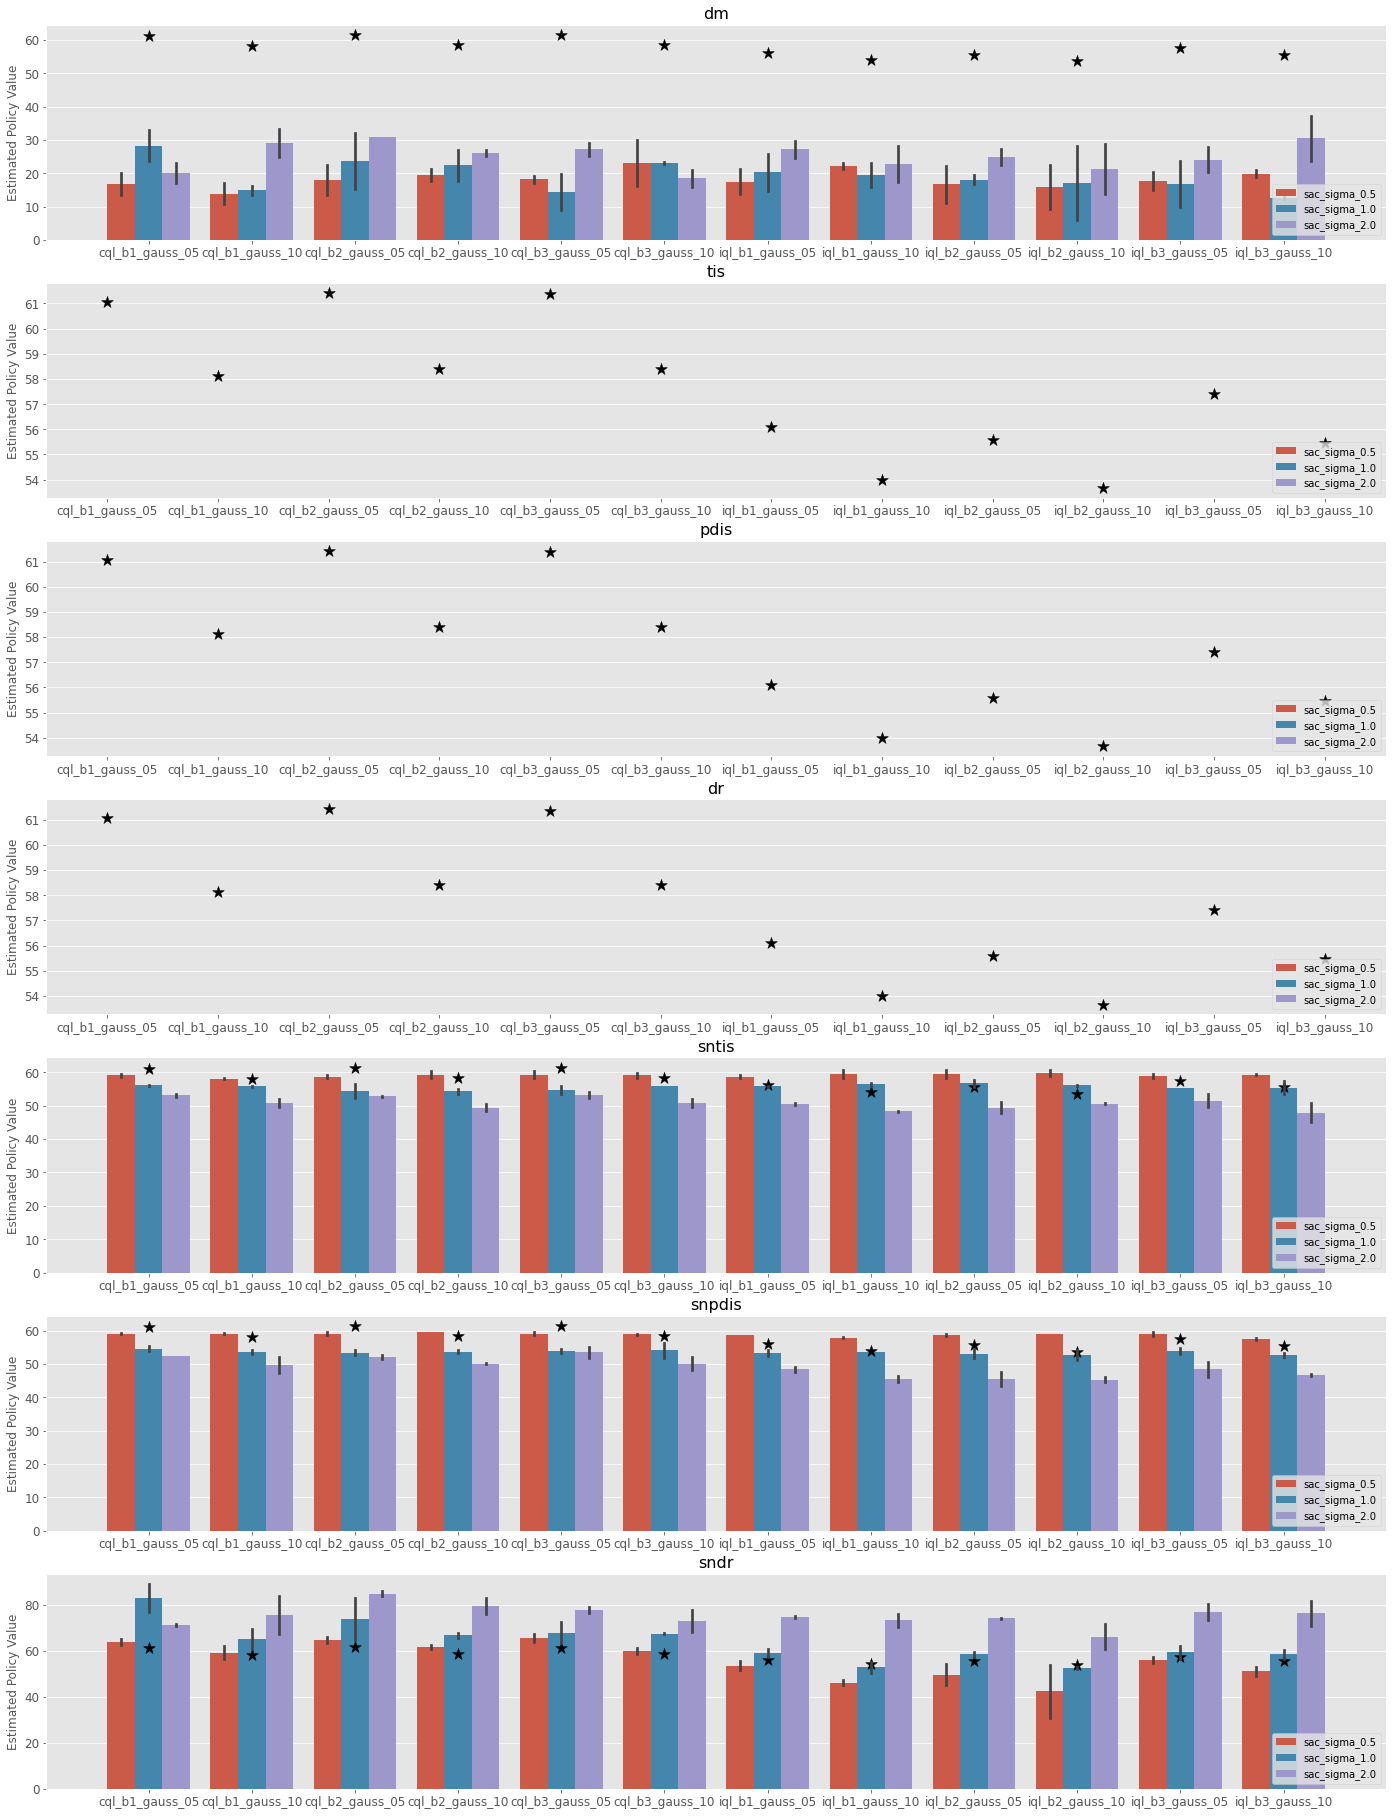

In [29]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

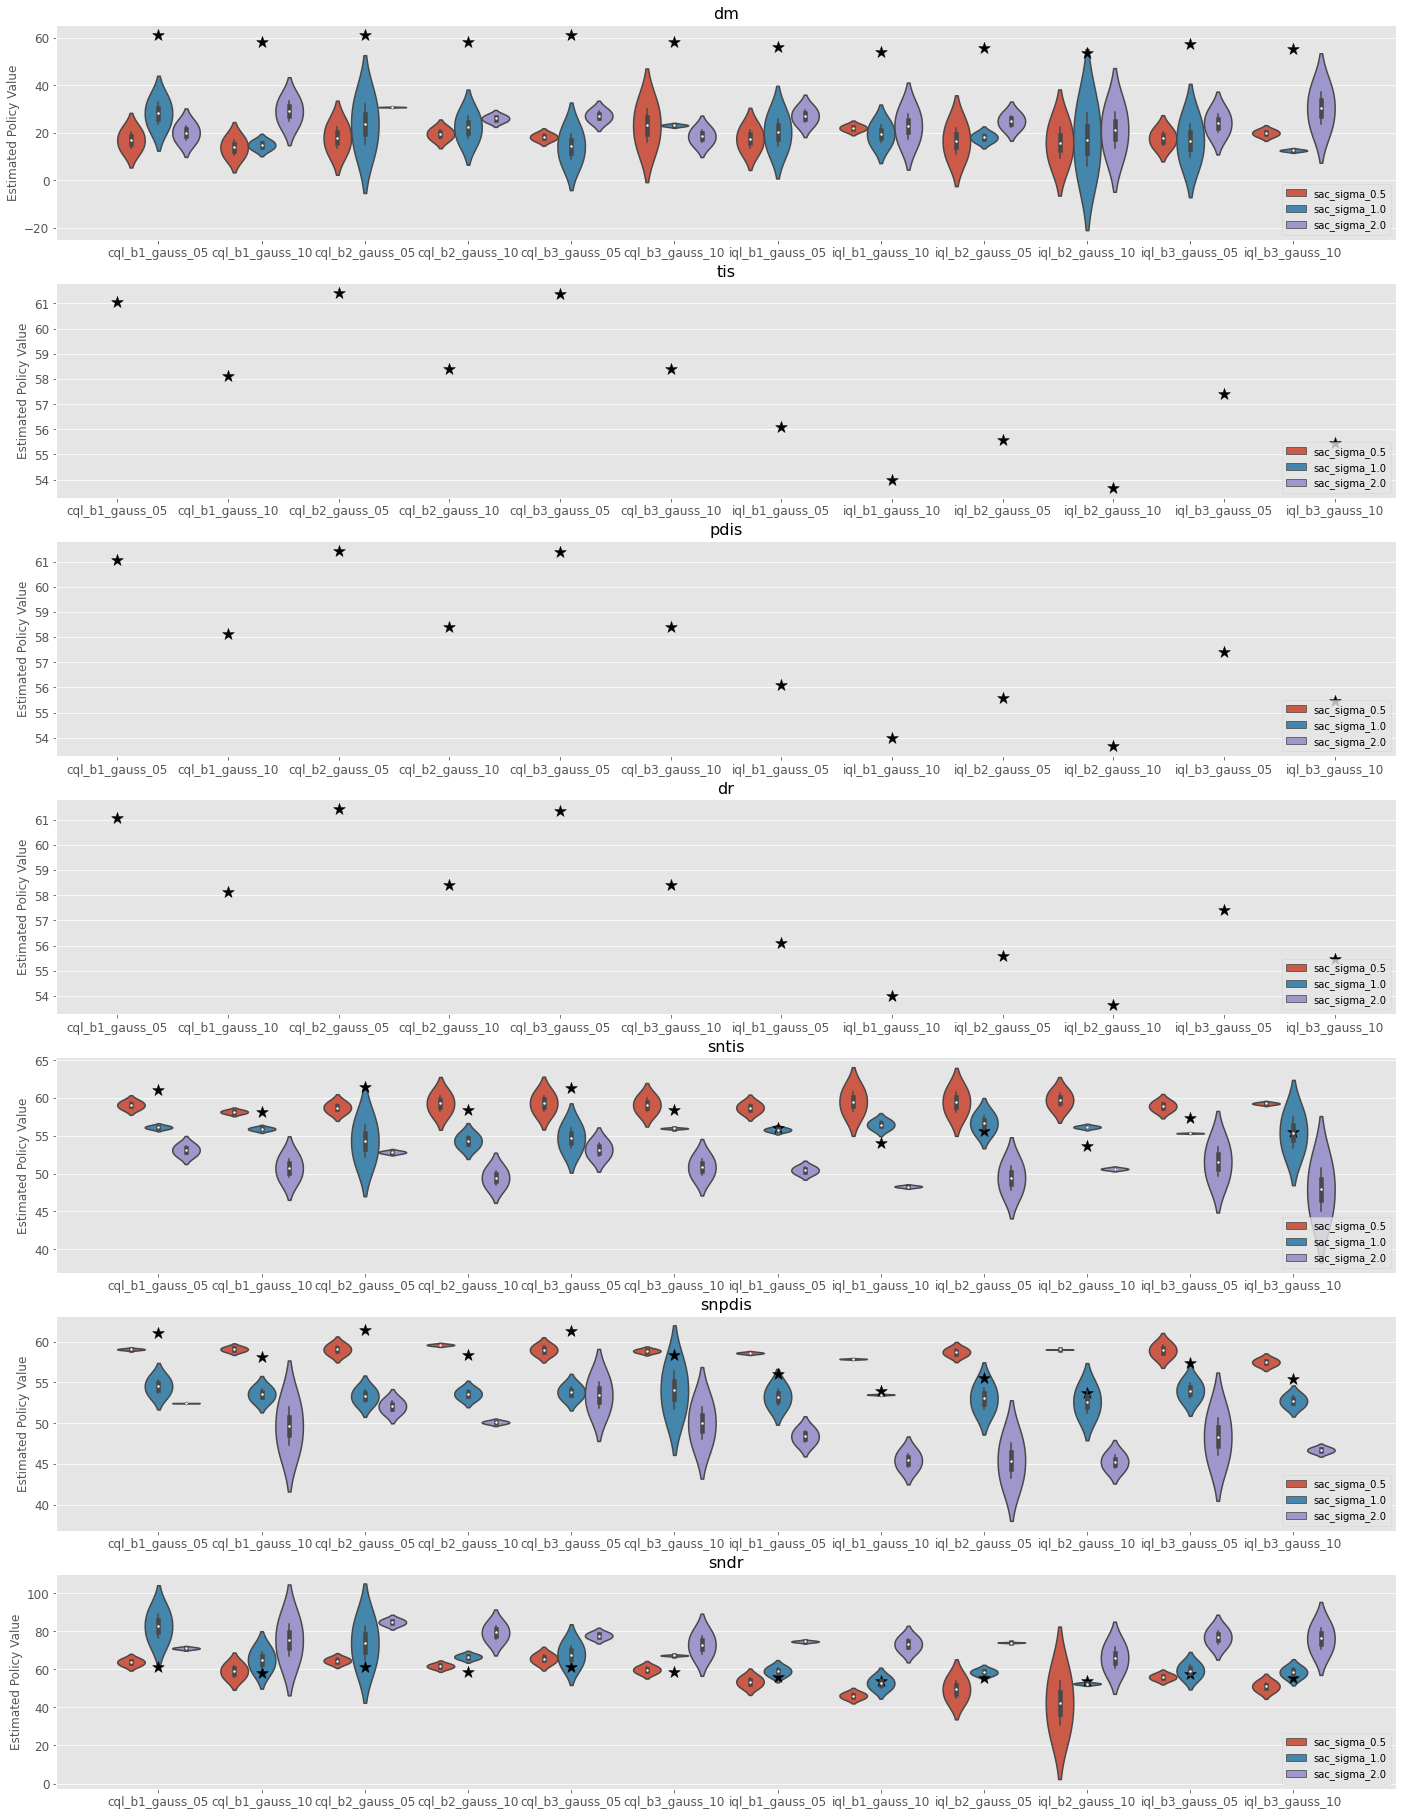

In [30]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

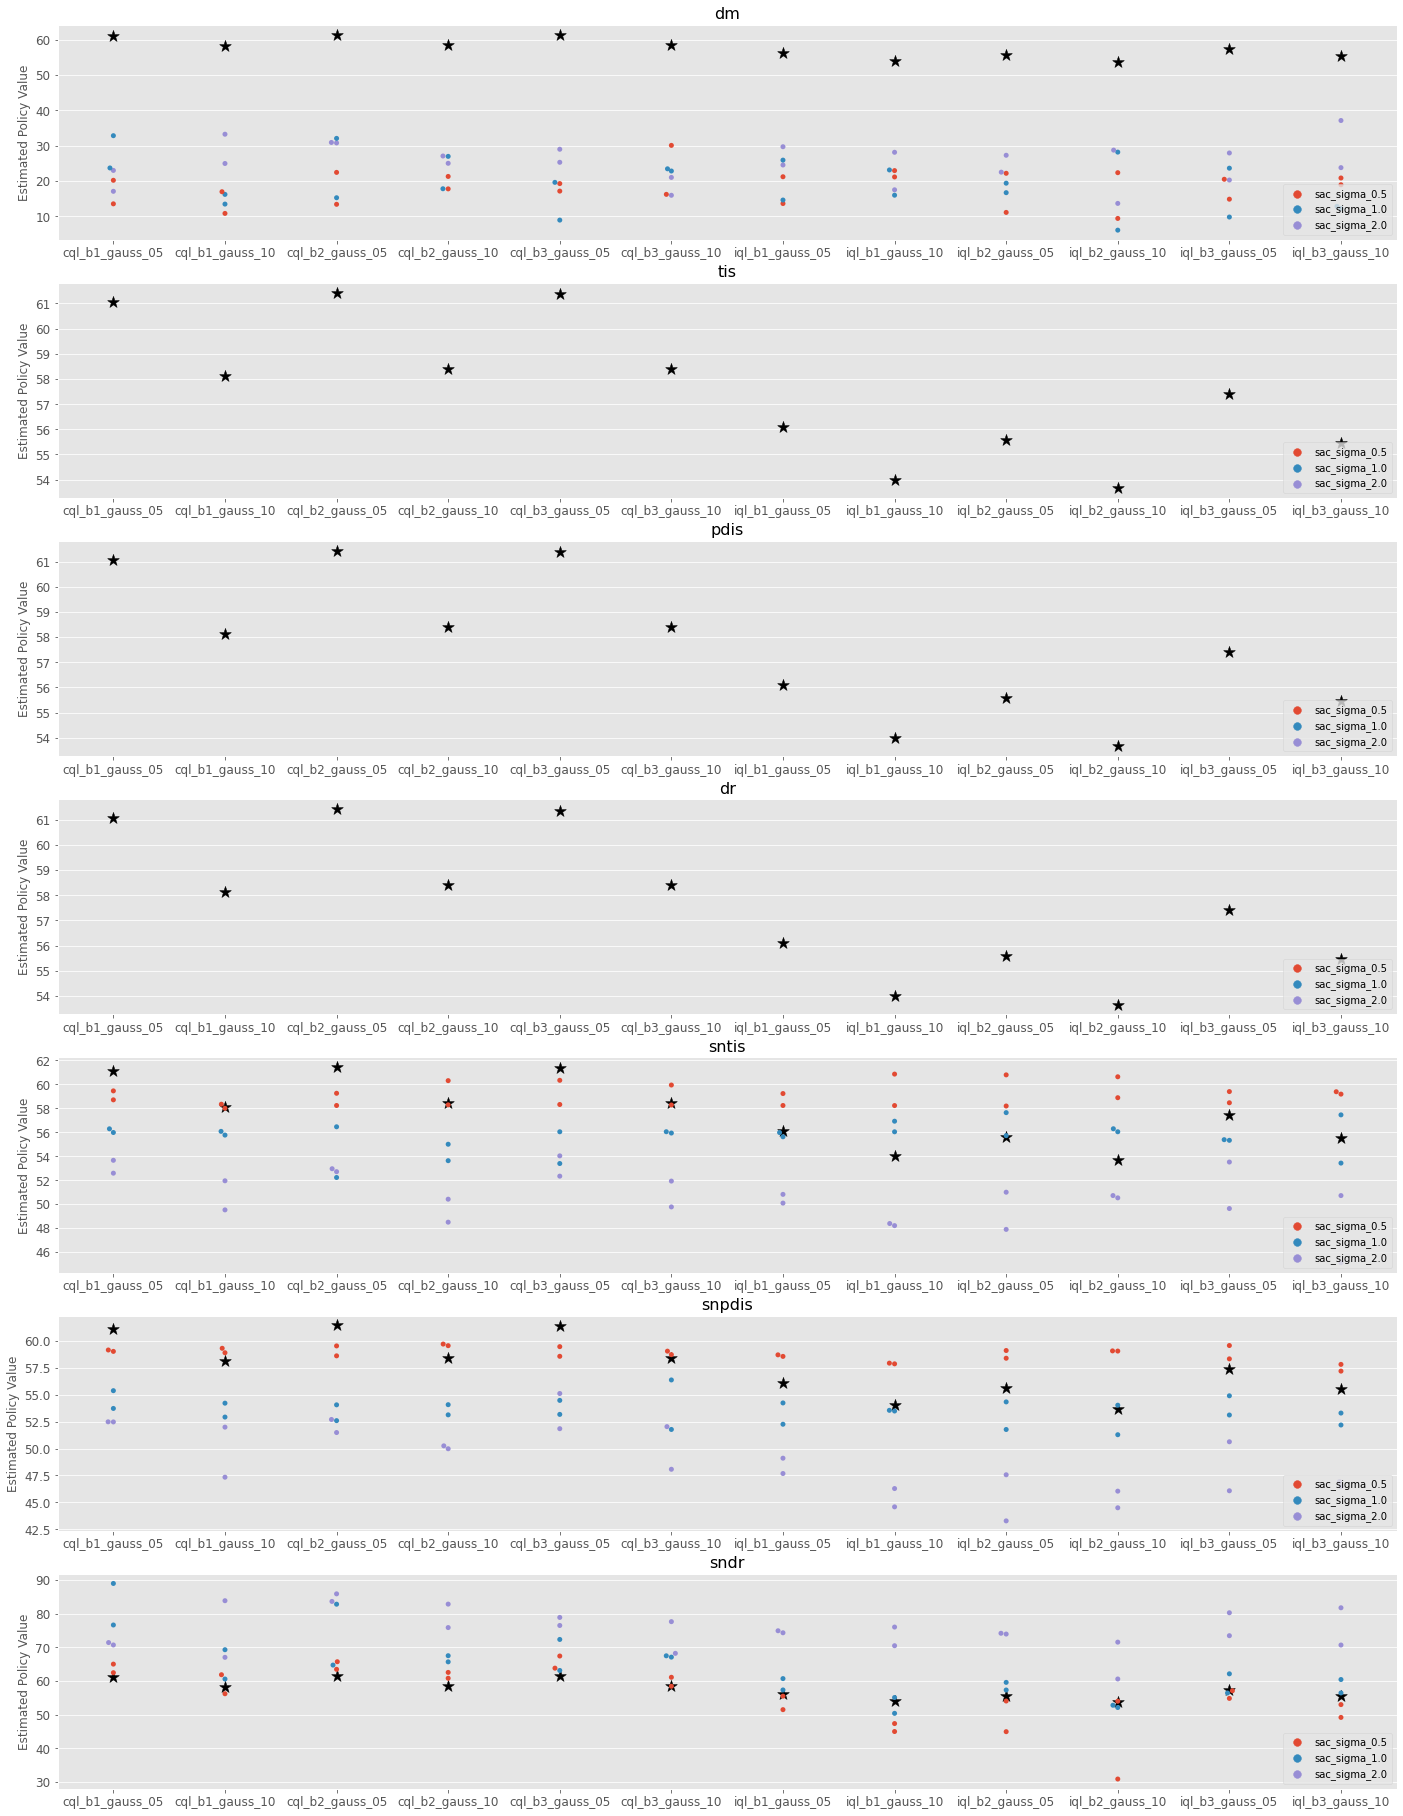

In [31]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [33]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import ContinuousCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [34]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

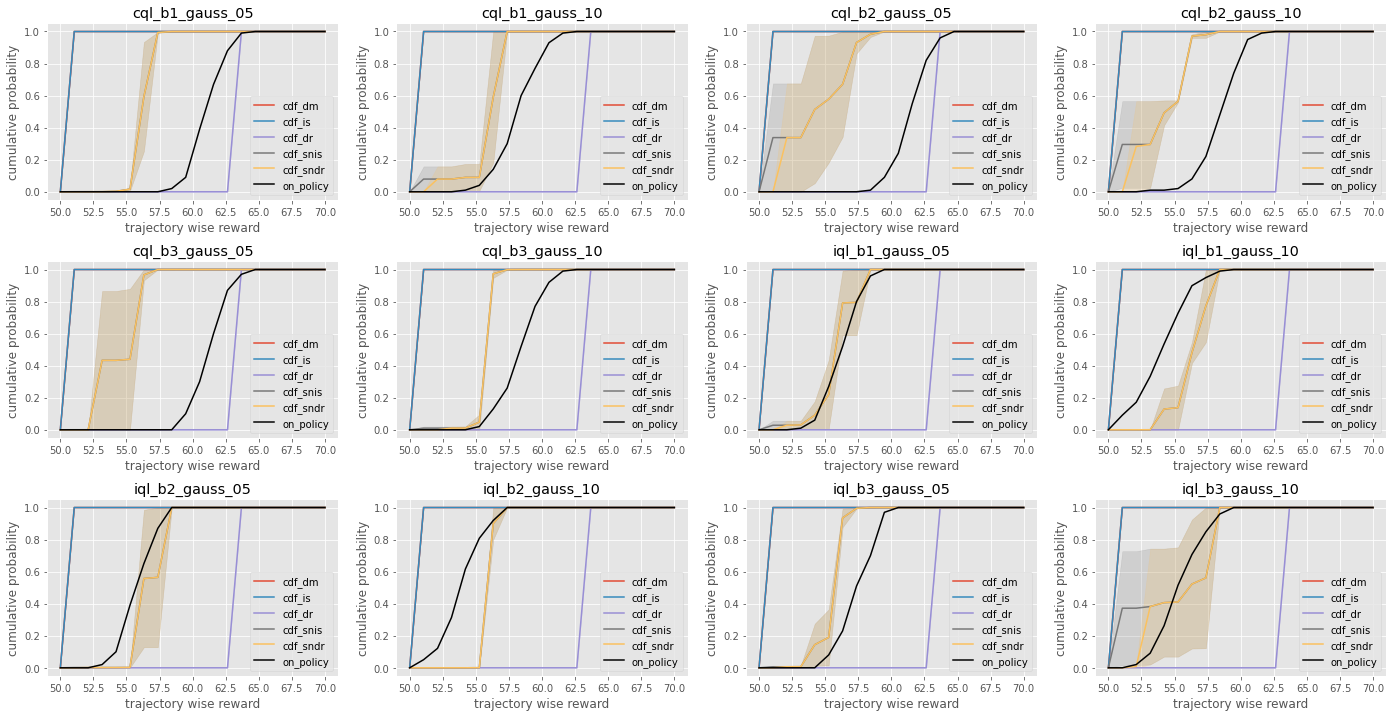

In [35]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="ci_hue",
    scale_min=50.0, 
    scale_max=70.0, 
    n_partition=20, 
    n_cols=4,
)

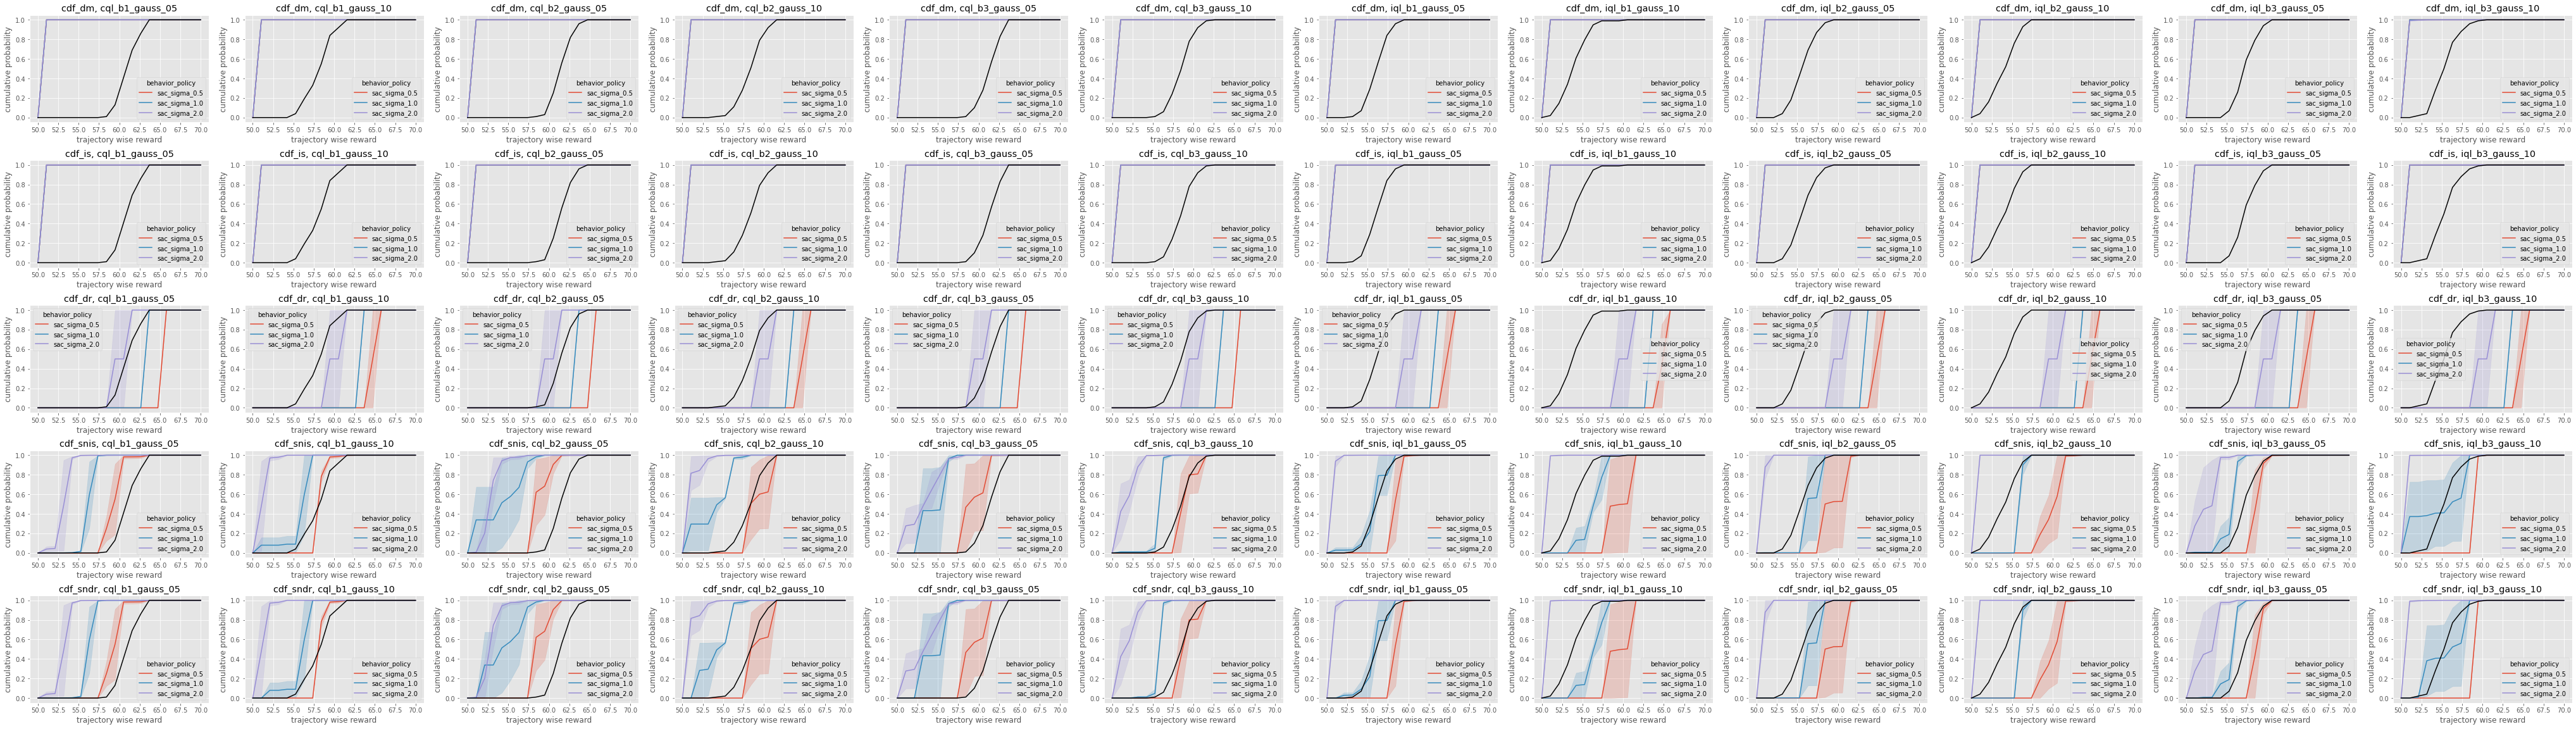

In [36]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=50.0, 
    scale_max=70.0, 
    n_partition=20, 
)

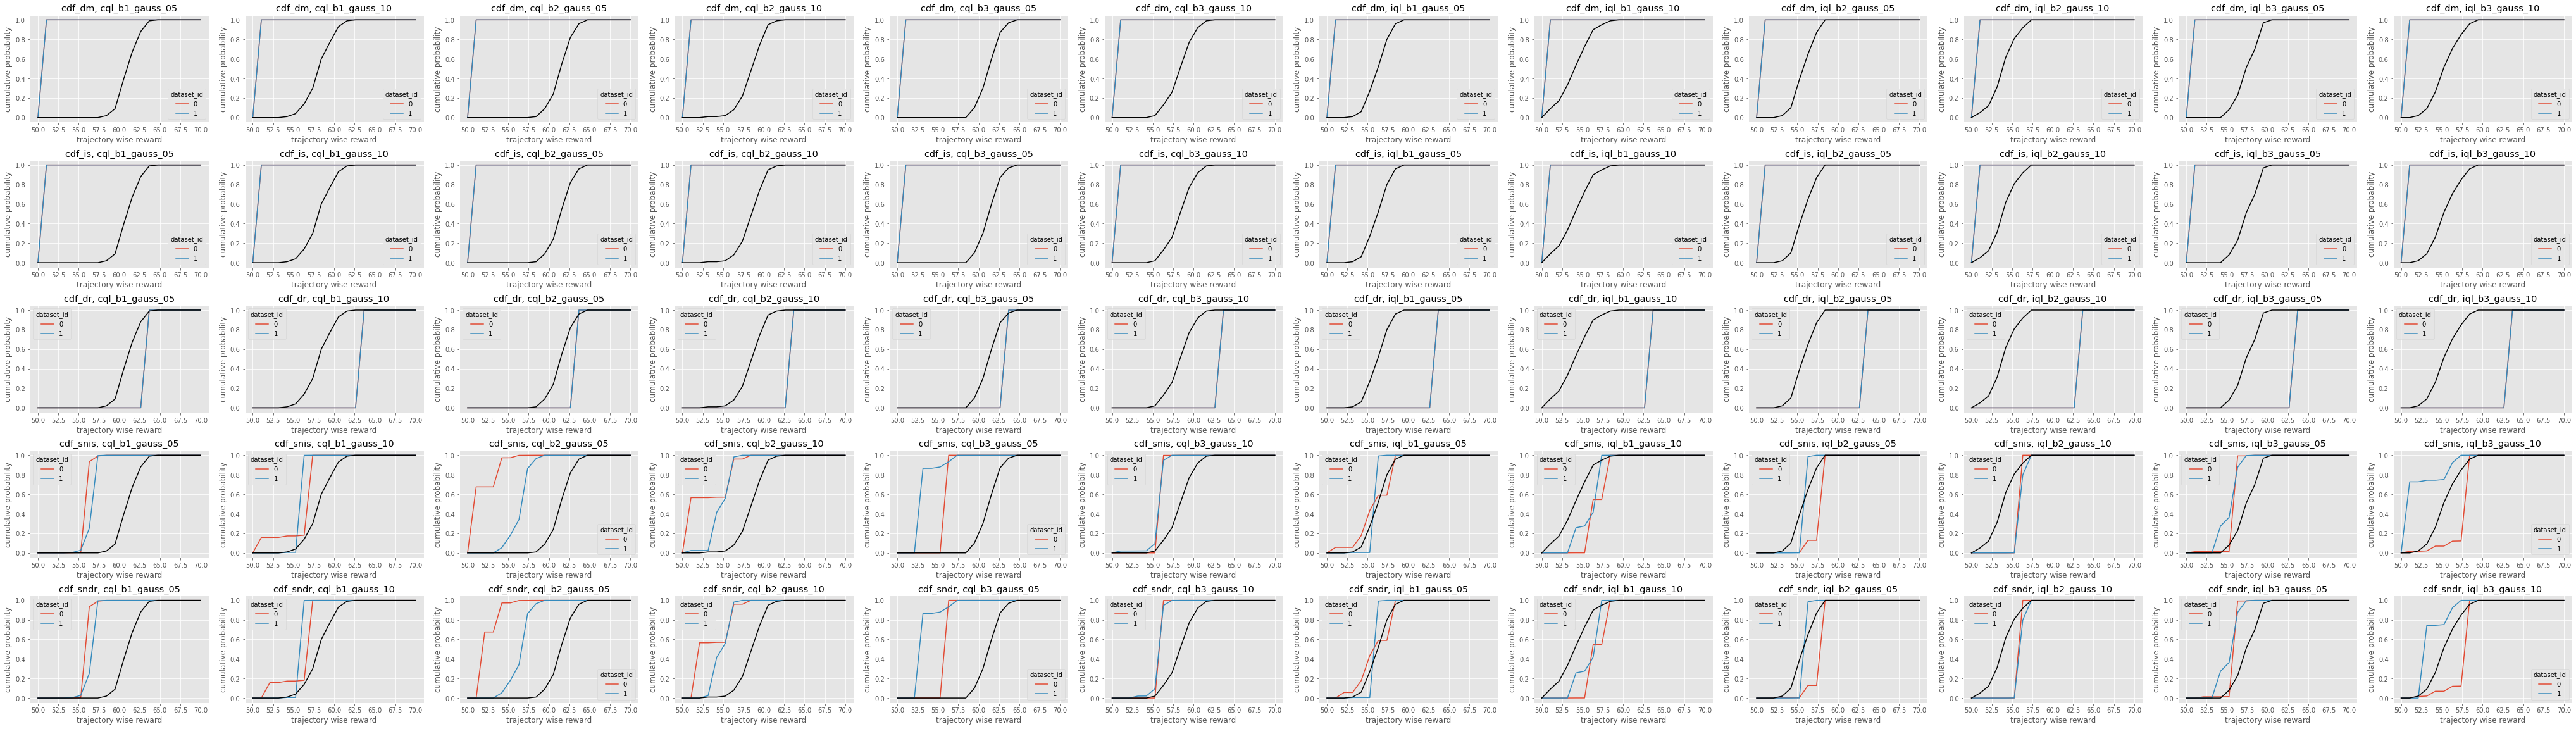

In [37]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="enumerate",
    hue="policy",
    scale_min=50.0, 
    scale_max=70.0, 
    n_partition=20, 
)

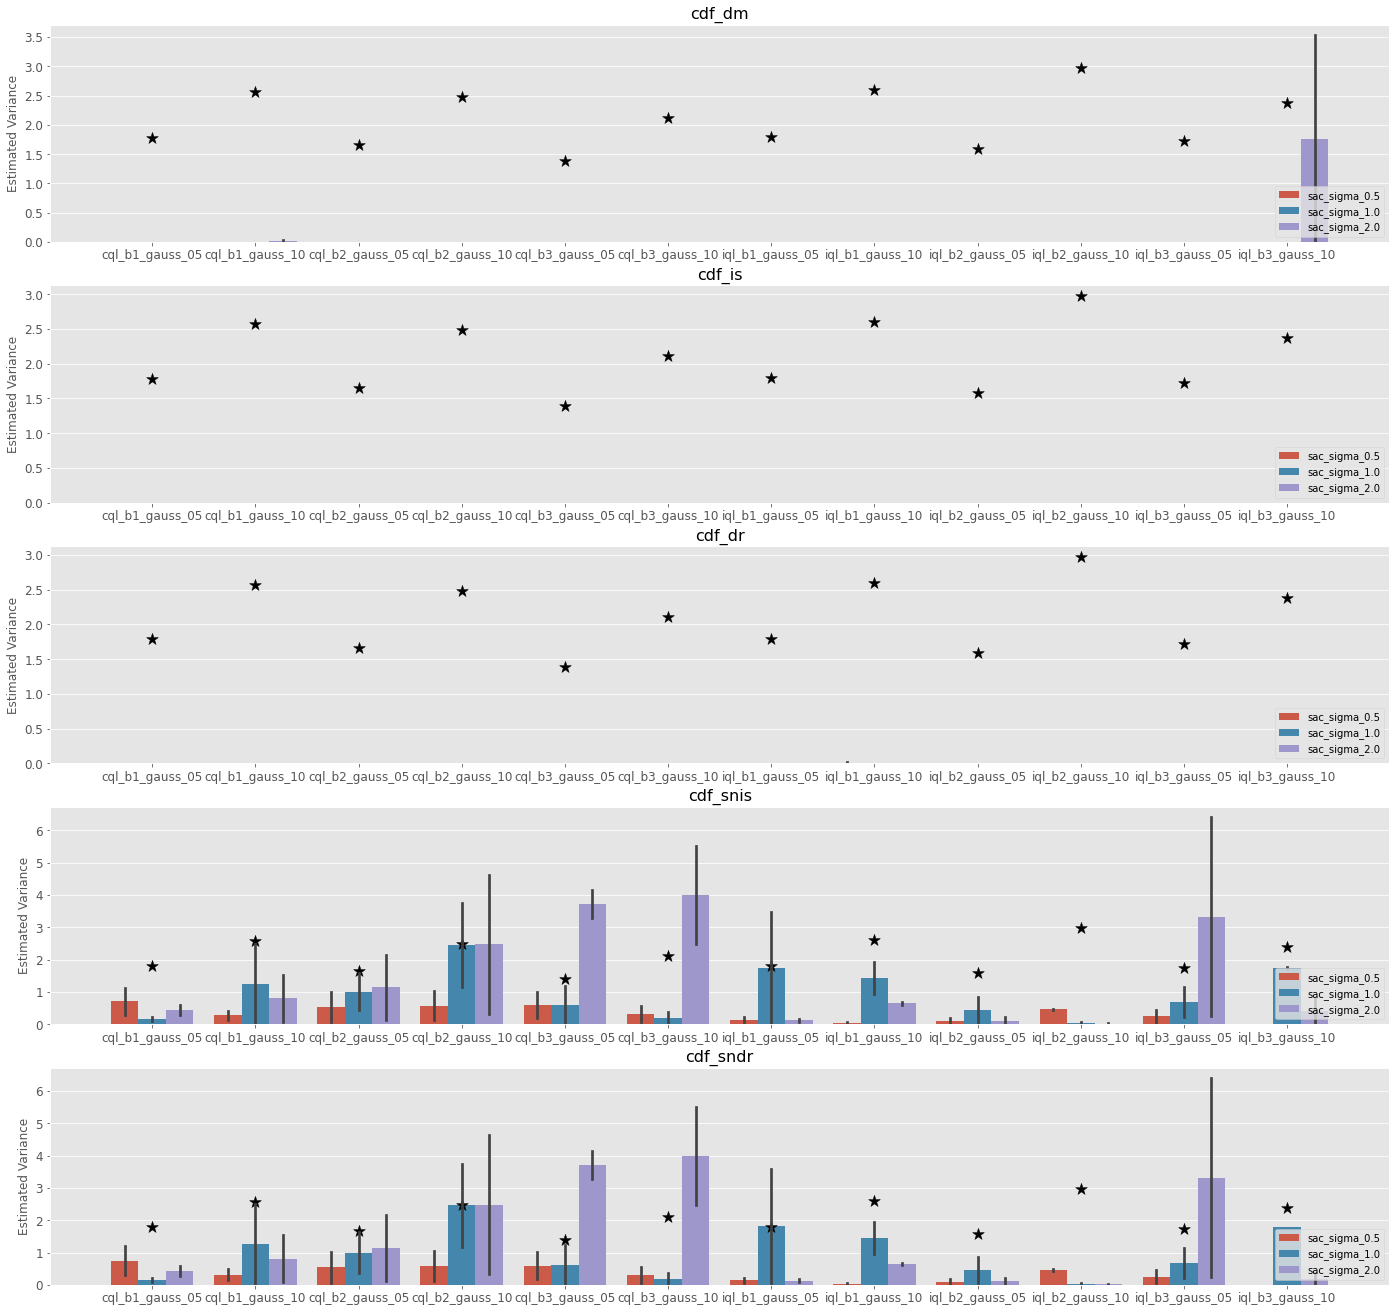

In [38]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

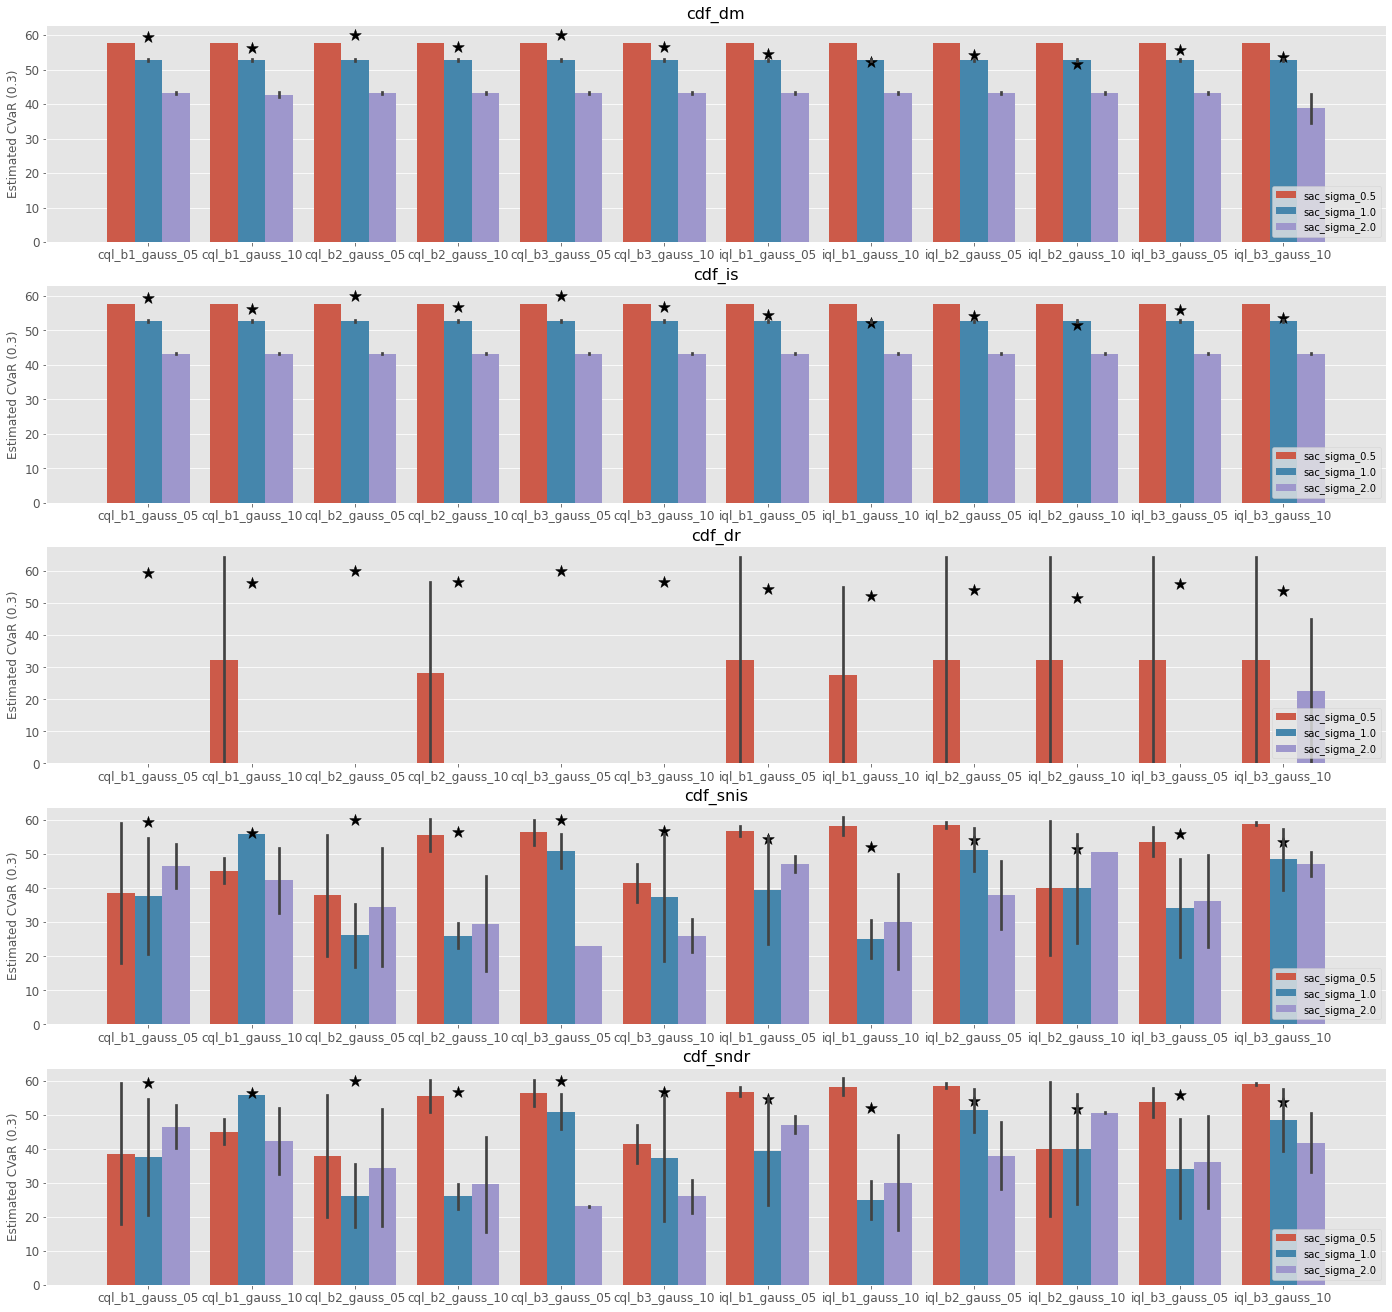

In [39]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

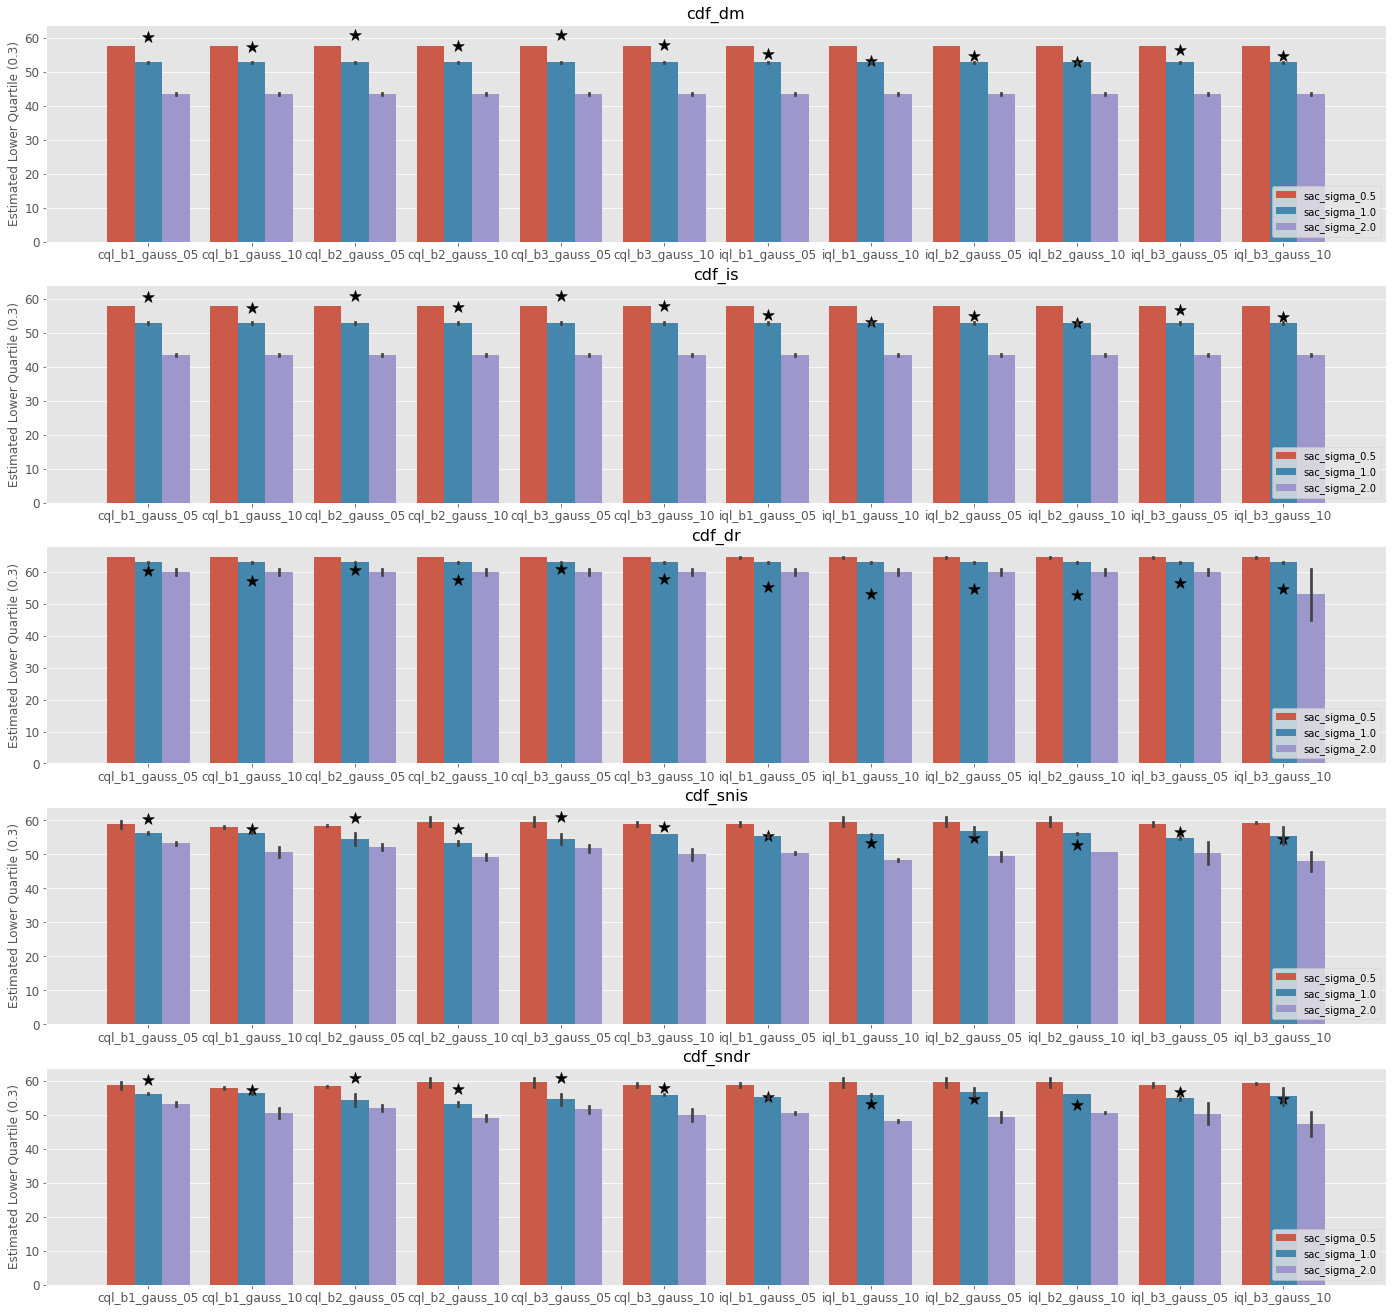

In [40]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [50]:
from ofrl.ope import OffPolicySelection

In [51]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [156]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result[behavior_policies[0].name][0]

ranking  policy_value  relative_policy_value  variance  \
0   cql_b2_gauss_05     61.425833               1.006729  1.658261   
1   cql_b3_gauss_05     61.363921               1.005715  1.388641   
2   cql_b1_gauss_05     61.069709               1.000893  1.784372   
3   cql_b3_gauss_10     58.410882               0.957316  2.109763   
4   cql_b2_gauss_10     58.398453               0.957113  2.481115   
5   cql_b1_gauss_10     58.111091               0.952403  2.566798   
6   iql_b3_gauss_05     57.403393               0.940804  1.722582   
7   iql_b1_gauss_05     56.086855               0.919227  1.795163   
8   iql_b2_gauss_05     55.580902               0.910935  1.586046   
9   iql_b3_gauss_10     55.472853               0.909164  2.375348   
10  iql_b1_gauss_10     53.994570               0.884936  2.596872   
11  iql_b2_gauss_10     53.654477               0.879362  2.977404   

   ranking_by_lower_quartile  lower_quartile  \
0            cql_b1_gauss_05       59.568738   
1            cql_b1_gauss_10       59.477401   
2            cql_b2_gauss_05       58.877568   
3            cql_b2_gauss_10       56.006854   
4            cql_b3_gauss_05       55.620475   
5            cql_b3_gauss_10       55.365316   
6            iql_b1_gauss_05       55.185287   
7            iql_b1_gauss_10       53.879779   
8            iql_b2_gauss_05       53.616141   
9            iql_b2_gauss_10       53.086045   
10           iql_b3_gauss_05       51.233975   
11           iql_b3_gauss_10       51.049216   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                       cql_b2_gauss_05                  59.367104  
1                       cql_b3_gauss_05                  59.134787  
2                       cql_b1_gauss_05                  58.561858  
3                       cql_b2_gauss_10                  55.494644  
4                       cql_b3_gauss_10                  55.333548  
5                       iql_b3_gauss_05                  54.970476  
6                       cql_b1_gauss_10                  54.781218  
7                       iql_b1_gauss_05                  53.568331  
8                       iql_b2_gauss_05                  53.123291  
9                       iql_b3_gauss_10                  52.473834  
10                      iql_b1_gauss_10                  50.609598  
11                      iql_b2_gauss_10                  50.210485

In [157]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [158]:
ranking_df[behavior_policies[0].name][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0    cql_b3_gauss_10               30.081319                         0.493013   
 1    cql_b2_gauss_05               22.440967                         0.367793   
 2    iql_b2_gauss_05               22.184508                         0.363590   
 3    iql_b1_gauss_10               21.150816                         0.346648   
 4    iql_b3_gauss_05               20.497169                         0.335935   
 5    cql_b1_gauss_05               20.205138                         0.331149   
 6    cql_b3_gauss_05               19.275889                         0.315919   
 7    iql_b3_gauss_10               18.942130                         0.310449   
 8    cql_b2_gauss_10               17.778455                         0.291377   
 9    cql_b1_gauss_10               16.972305                         0.278165   
 10   iql_b1_gauss_05               13.628345                         0.223360   
 11   iql_

In [159]:
metric_df[behavior_policies[0].name][0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm        1.479690e+03          0.377622  0.226206  3.014951   
1       tis        9.429378e+55          0.811189  0.001363  0.061912   
2      pdis        2.317280e+55          0.741259  0.005801  3.314742   
3        dr        4.970595e+54          0.195804  0.541936  3.314742   
4     sntis        7.800270e+00          0.000000  1.000000  0.356124   
5    snpdis        7.109358e+00          0.489510  0.106252  4.022441   
6      sndr        2.334497e+01          0.902098  0.000060  0.061912   

   type_i_error_rate  type_ii_error_rate  
0           0.000000                 0.0  
1           0.000000                 0.0  
2           0.000000                 0.0  
3           0.416667                 0.0  
4           0.000000                 0.0  
5           0.000000                 0.0  
6           0.000000                 0.0

In [160]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    safety_threshold=55.0,
    return_by_dataframe=True,
)

In [161]:
topk_metric_df[:30]

estimator  topk       k-th       best      worst       mean       std  \
0         dm     0  56.771594  56.771594  56.771594  56.771594       NaN   
1         dm     1  59.277777  59.320097  56.729274  58.024686  1.831989   
2         dm     2  58.416449  60.878682  55.415757  58.155273  2.896991   
3         dm     3  55.559308  60.878682  54.542763  57.506282  2.927472   
4         dm     4  57.240546  60.878682  54.542763  57.453135  2.624662   
5         dm     5  58.326628  61.355182  54.169727  57.598717  2.777655   
6         dm     6  57.844190  61.355182  53.906644  57.633785  2.823576   
7         dm     7  57.786456  61.355182  53.906644  57.652868  2.720896   
8         dm     8  57.761723  61.355182  53.906644  57.664963  2.658186   
9         dm     9  58.647975  61.421628  53.906644  57.763265  2.657030   
10        dm    10  56.082332  61.421628  53.877526  57.610453  2.603988   
11        dm    11  56.931942  61.421628  53.740695  57.553910  2.698286   
0        tis     0  57.049026  57.049026  57.049026  57.049026       NaN   
1        tis     1  56.870465  57.732892  56.186599  56.959745  1.093394   
2        tis     2  56.948808  58.119808  55.603198  56.956100  1.387102   
3        tis     3  56.617707  58.470583  55.259967  56.871501  1.526964   
4        tis     4  56.335866  58.562624  54.897278  56.764374  1.594737   
5        tis     5  59.324527  59.455620  54.897278  57.191066  1.828098   
6        tis     6  57.590496  59.728250  54.559906  57.248128  1.924311   
7        tis     7  56.678068  59.761062  54.397236  57.176870  2.036989   
8        tis     8  57.189680  60.356577  53.783015  57.178294  2.270390   
9        tis     9  57.880227  61.220005  53.783015  57.248487  2.354079   
10       tis    10  59.401951  61.399555  53.783015  57.444256  2.554478   
11       tis    11  58.760099  61.421628  53.740695  57.553910  2.698286   
0       pdis     0  55.646347  55.646347  55.646347  55.646347       NaN   
1       pdis     1  57.418898  57.732892  55.332354  56.532623  1.697436   
2       pdis     2  57.440364  58.119808  55.240510  56.835203  1.596493   
3       pdis     3  57.330713  58.470583  55.240510  56.959081  1.562512   
4       pdis     4  55.985549  58.562624  54.897278  56.764374  1.594737   
5       pdis     5  58.370948  59.455620  54.752379  57.032137  1.893668   

    safety_violation_rate  sharpe_ratio  
0                0.333333           NaN  
1                0.250000     -3.692734  
2                0.166667      1.333275  
3                0.250000      1.183633  
4                0.233333      1.313170  
5                0.194444      1.587023  
6                0.190476      1.533350  
7                0.166667      1.590402  
8                0.148148      1.635286  
9                0.133333      1.701567  
10               0.136364      1.714041  
11               0.166667      1.640694  
0                0.333333           NaN  
1                0.250000     -2.113647  
2                0.277778     -0.381138  
3                0.250000     -0.167840  
4                0.233333      4.206055  
5                0.194444      4.230353  
6                0.166667      1.565942  
7                0.166667      1.509331  
8                0.185185      1.727055  
9                0.166667      1.876543  
10               0.151515      1.732145  
11               0.166667      1.640694  
0                0.333333           NaN  
1                0.250000     -4.200658  
2                0.277778     -0.513959  
3                0.208333     -0.274076  
4                0.233333      4.206055  
5                0.194444      4.113838

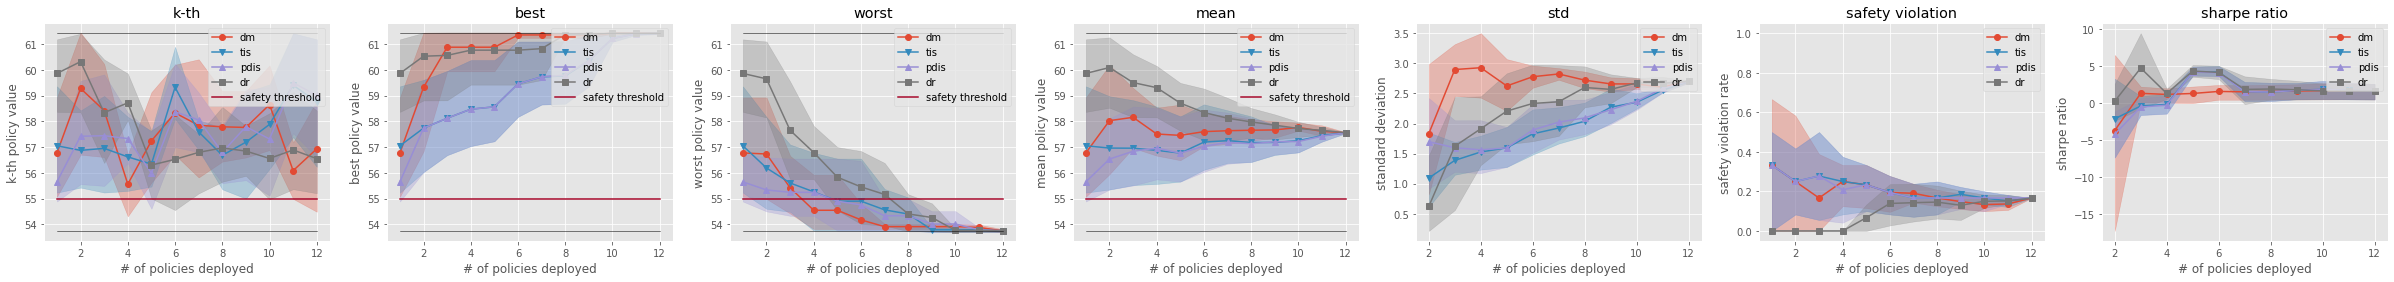

In [162]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_threshold=55.0,
    legend=True,
    random_state=random_state,
)

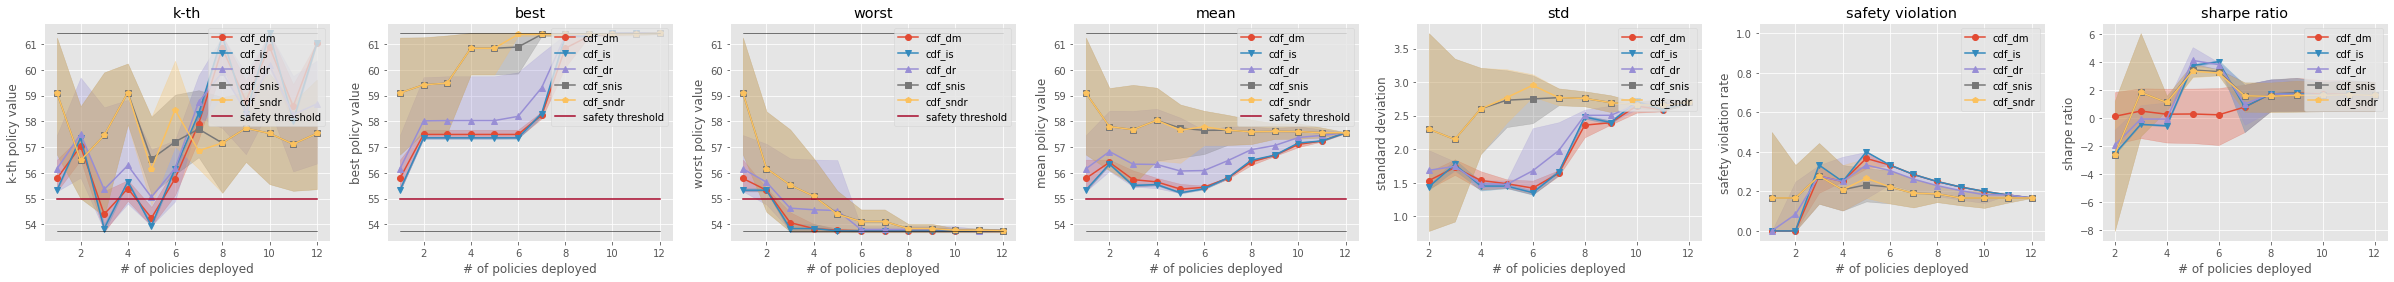

In [163]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_threshold=55.0,
    legend=True,
    random_state=random_state,
)

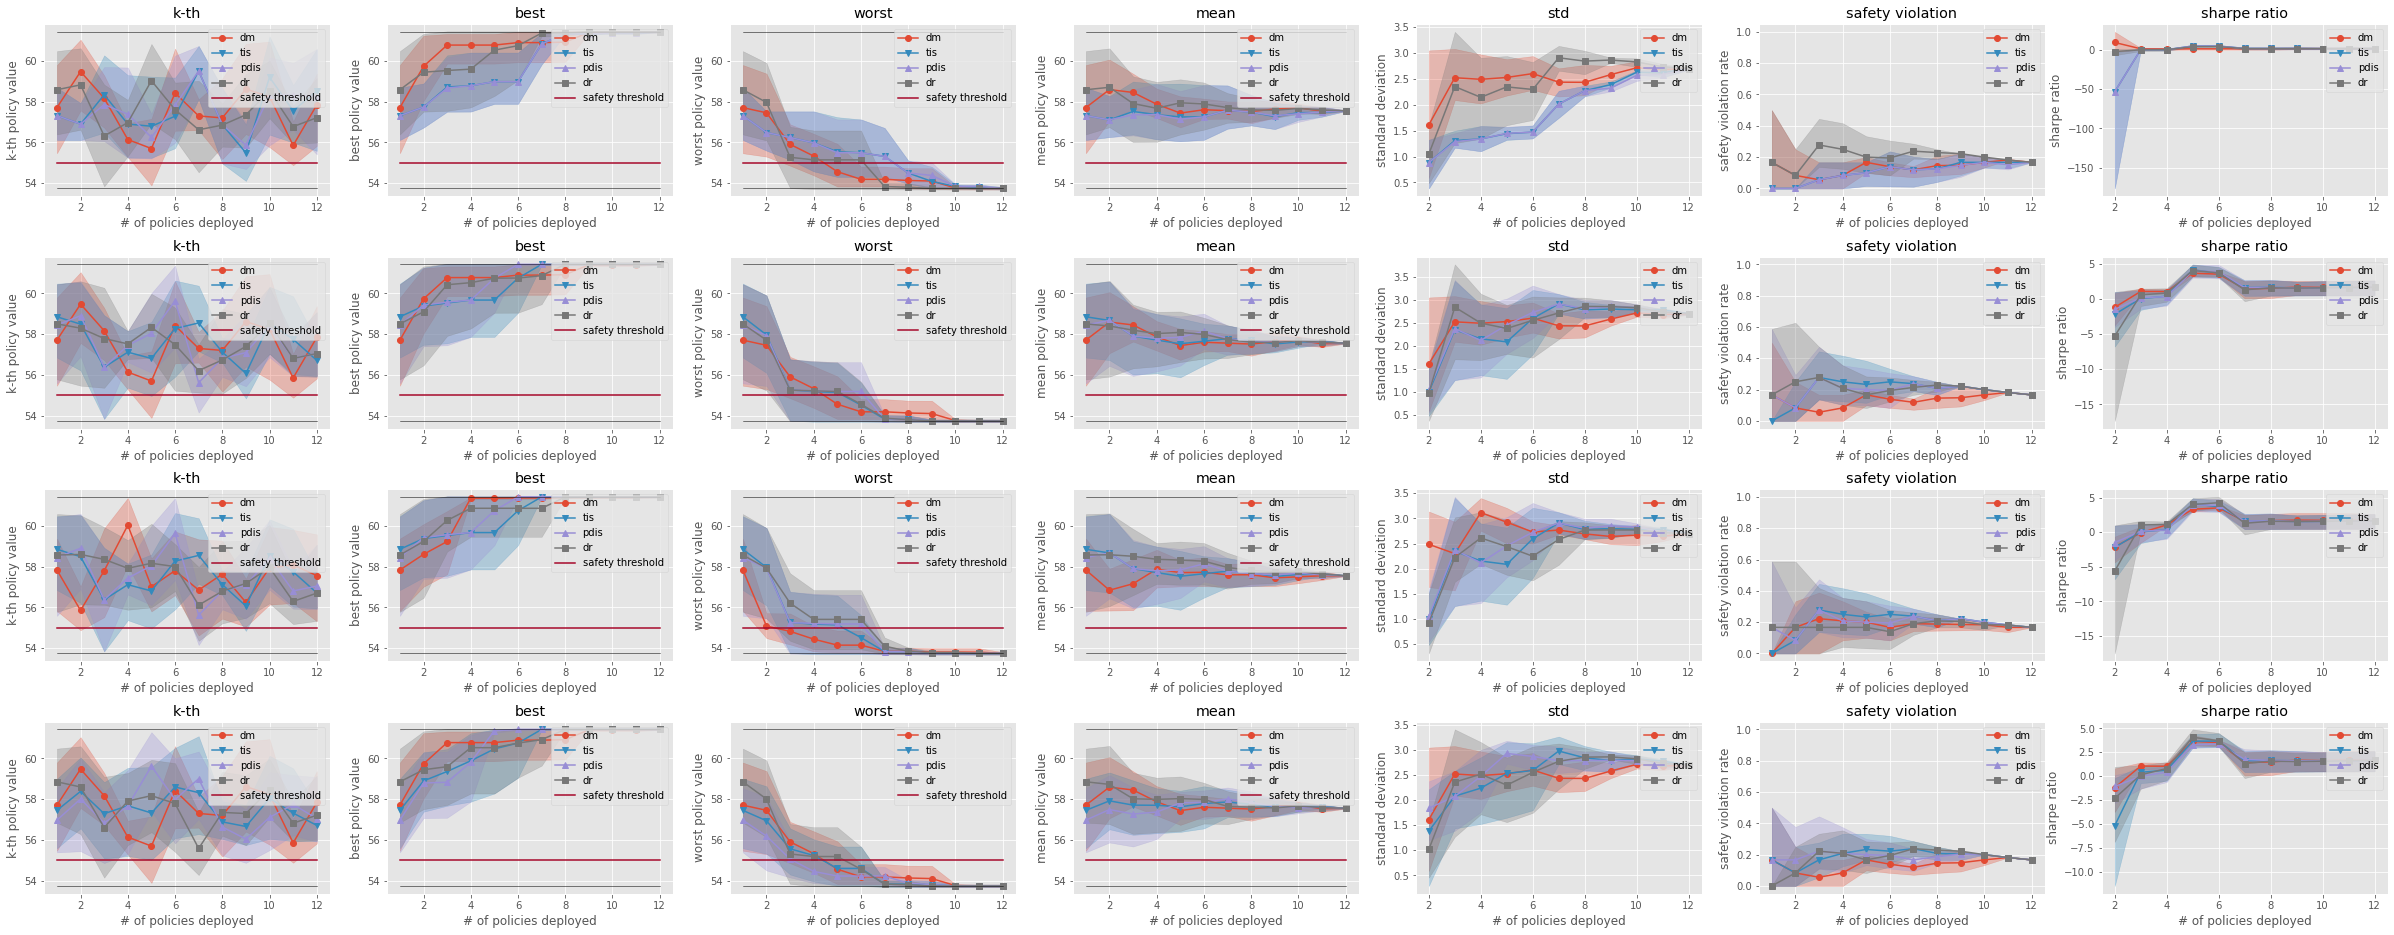

In [164]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_threshold=55.0,
    legend=True,
    random_state=random_state,
)

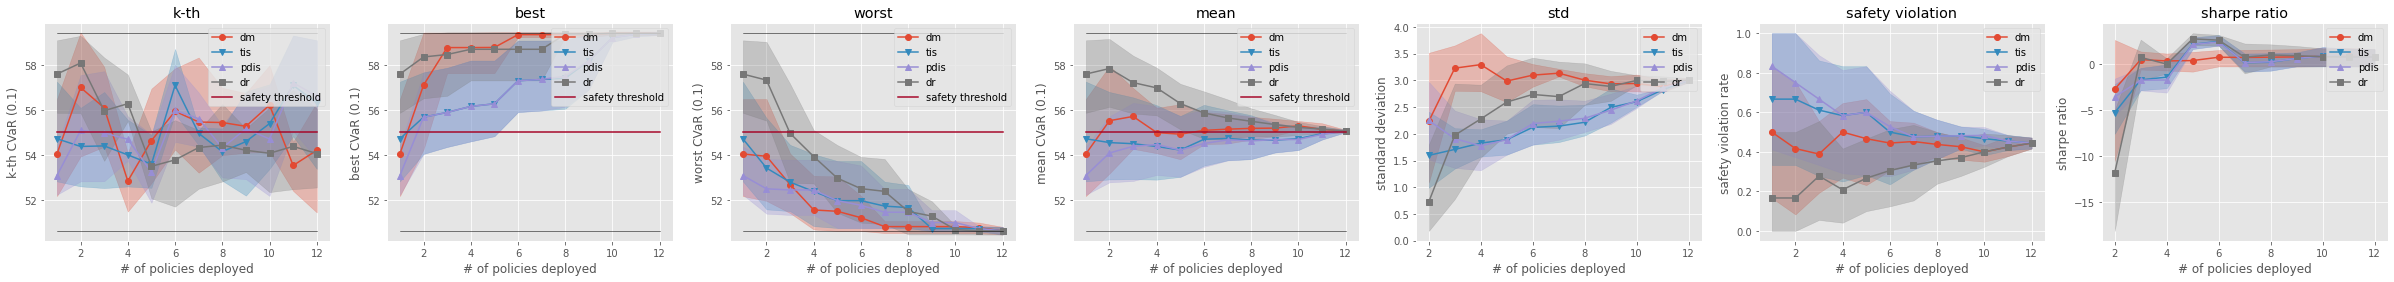

In [165]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=55.0,
    legend=True,
    random_state=random_state,
)

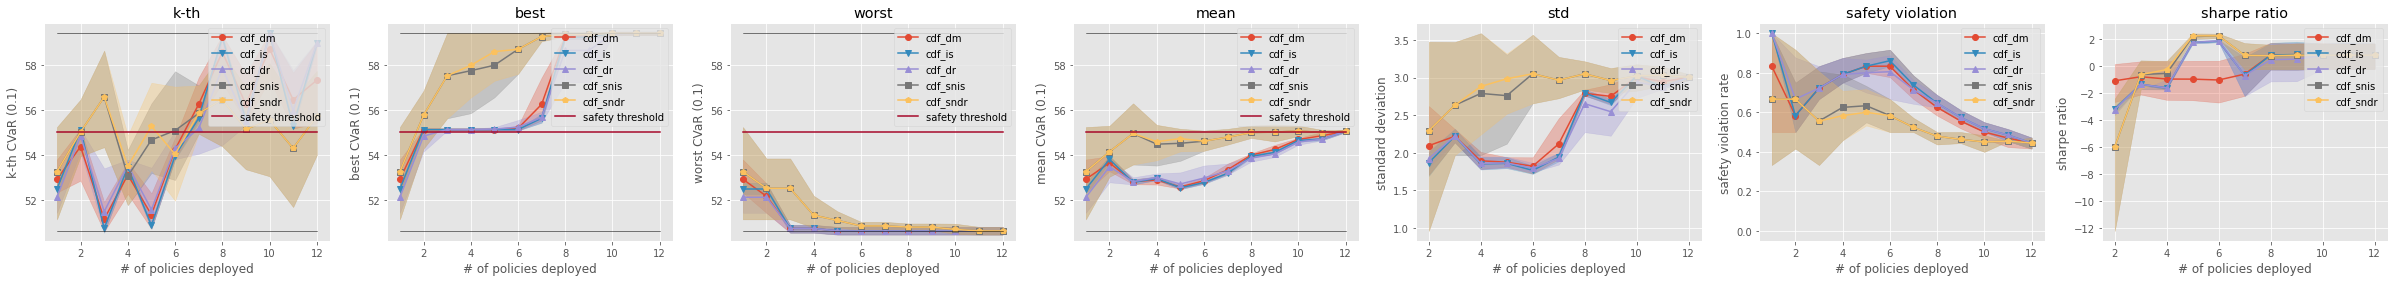

In [166]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=55.0,
    legend=True,
    random_state=random_state,
)

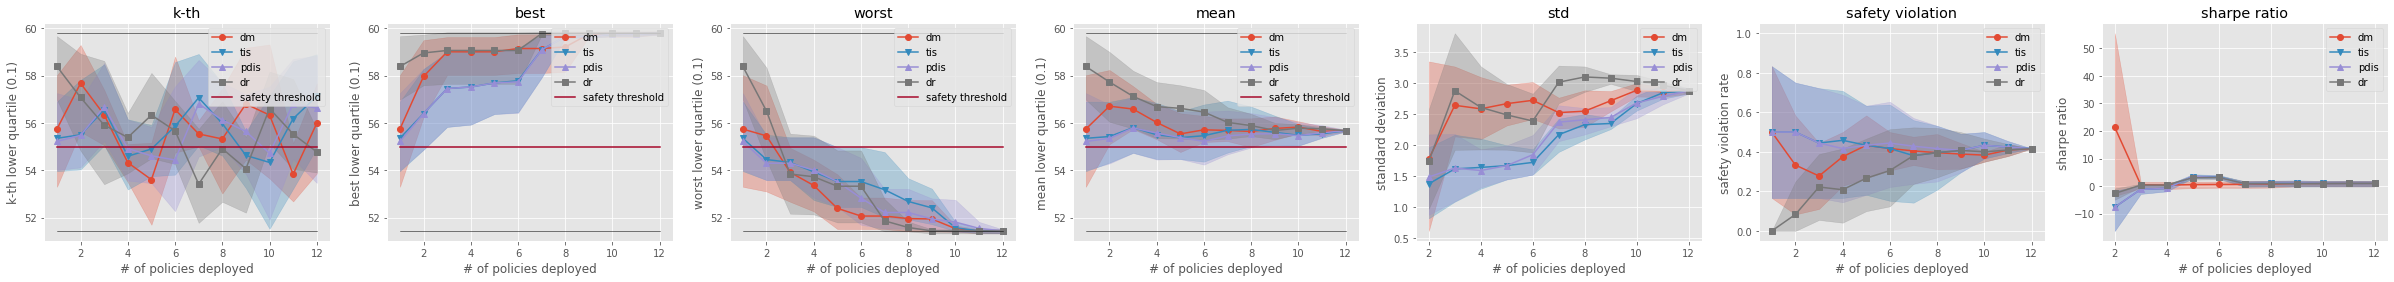

In [167]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=55.0,
    legend=True,
    random_state=random_state,
)

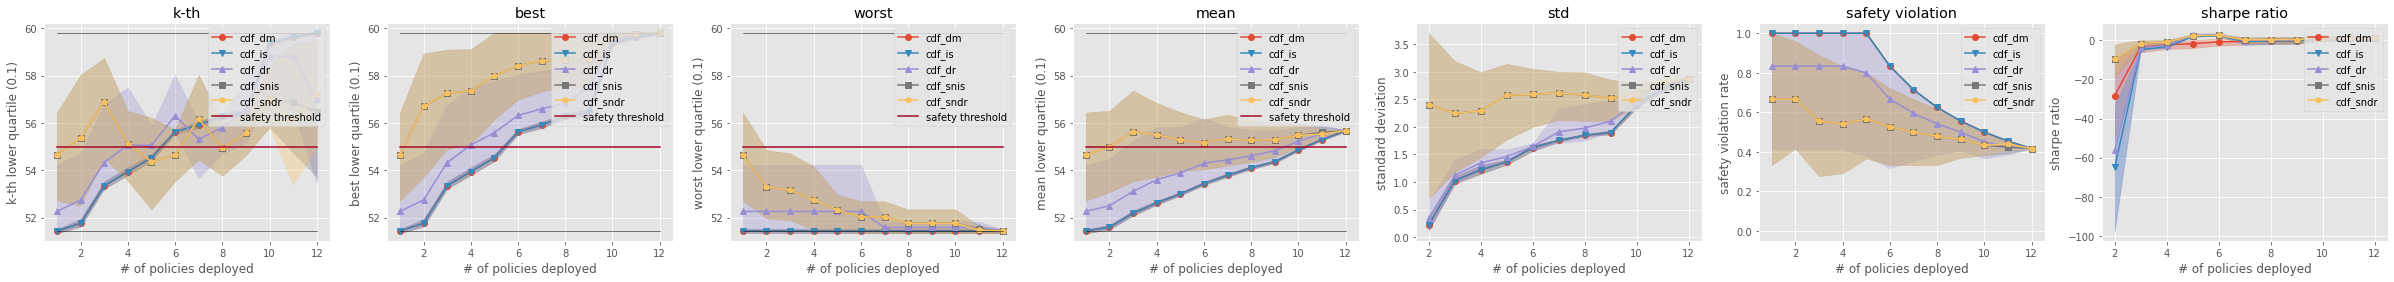

In [168]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=55.0,
    legend=True,
    random_state=random_state,
)

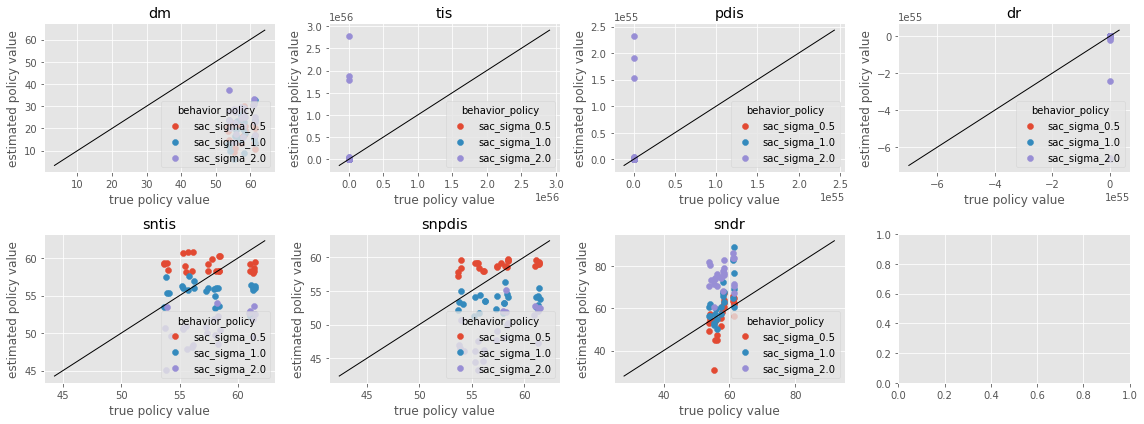

In [169]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=False,
)

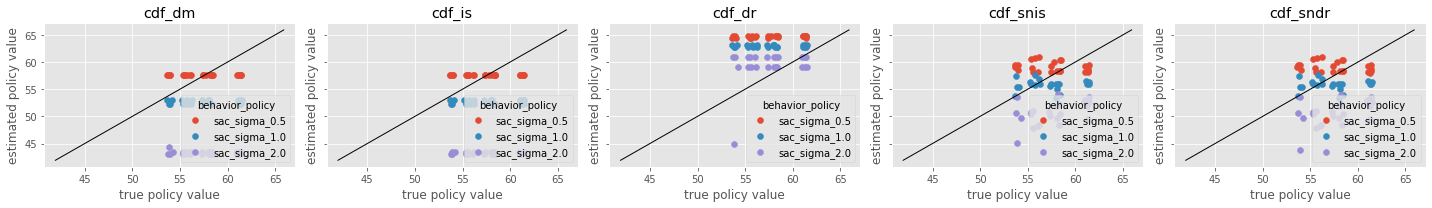

In [170]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

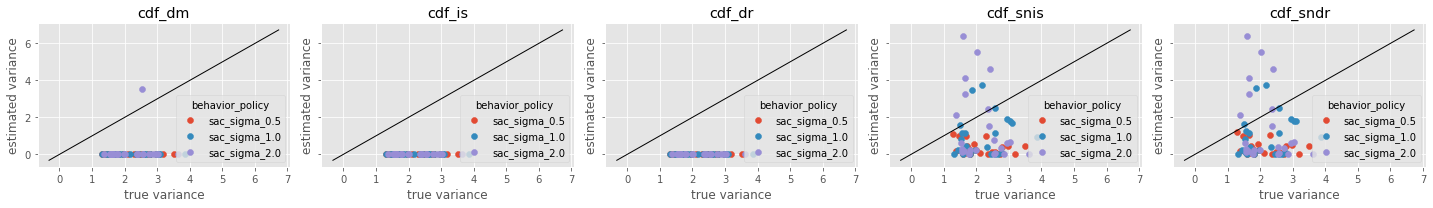

In [171]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

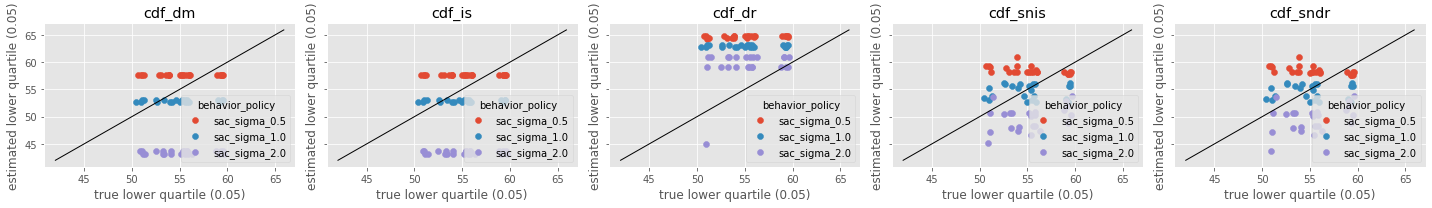

In [172]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

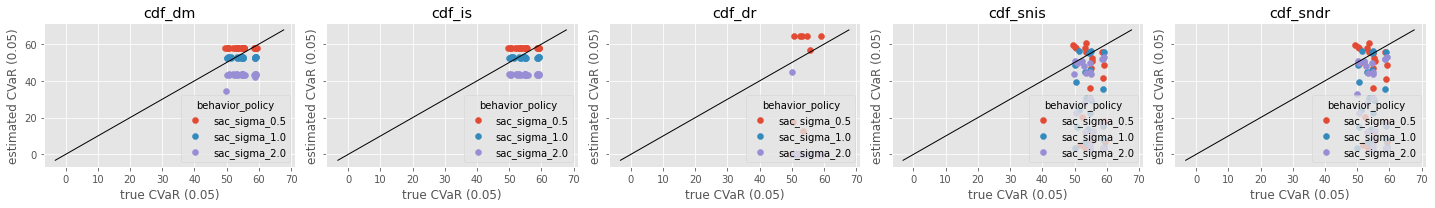

In [173]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

<!-- For the examples in the continuous action space, please refer to [examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb). -->

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.